# EDA данных с новостного сайта РИА Новости

## Часть 1.2. Первичный анализ данных

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from scipy.stats import shapiro

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download("stopwords")

sns.set(style="darkgrid")
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

import tqdm

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anast\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_pickle("ria_news_full.p", compression="gzip")
df.drop(columns="id", inplace=True)
df = df.reset_index(drop=True)

In [3]:
f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов"

'Размер датасета: 25565 строк, 6 столбцов'

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25565 entries, 0 to 25564
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       25565 non-null  object
 1   title     25565 non-null  object
 2   subtitle  25565 non-null  object
 3   content   25565 non-null  object
 4   datetime  25565 non-null  object
 5   topic     25565 non-null  object
dtypes: object(6)
memory usage: 1.2+ MB


Все данные имеют строковый формат. Для даты мы это исправим ниже. 

In [5]:
f"Количество дубликатов: {df.duplicated().sum()}"

'Количество дубликатов: 1579'

In [6]:
df = df[~df.duplicated()]
df.shape

(23986, 6)

In [7]:
df.topic.value_counts()

topic
science      3942
incidents    3854
culture      3838
politics     3467
world        3320
economy      2813
society      2752
Name: count, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23986 entries, 0 to 25560
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   url       23986 non-null  object
 1   title     23986 non-null  object
 2   subtitle  23986 non-null  object
 3   content   23986 non-null  object
 4   datetime  23986 non-null  object
 5   topic     23986 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


Пустые строки не отображаются как nan значения, поэтому проверим отдельно, есть ли у нас в столбцах пустые строки.

In [9]:
df.content.apply(lambda x: len(x) == 0).sum()

1

In [10]:
df.title.apply(lambda x: len(x) == 0).sum()

0

In [11]:
df.subtitle.apply(lambda x: len(x) == 0).sum()

3767

In [12]:
df.datetime.apply(lambda x: len(x) == 0).sum()

0

Мы видим, что отсутствует основной текст в одной новости. И в 3684 строках нет второго заголовка. На этот признак опираться не будем, а 1 строку с пустым текстом удалим из нашего датафрейма.

In [13]:
df = df[~df.content.apply(lambda x: len(x) == 0)]

In [14]:
df.shape

(23985, 6)

### Распределение количества новостей по темам

In [15]:
print("\nThe size of each topic category\n")
pd.DataFrame(
    {"Topic": df.topic.value_counts().index, "Count": df.topic.value_counts().values}
)


The size of each topic category



Topic  Count
0    science   3942
1  incidents   3854
2    culture   3838
3   politics   3467
4      world   3319
5    economy   2813
6    society   2752

Немного проседают по количеству категории "society" и "economy".  

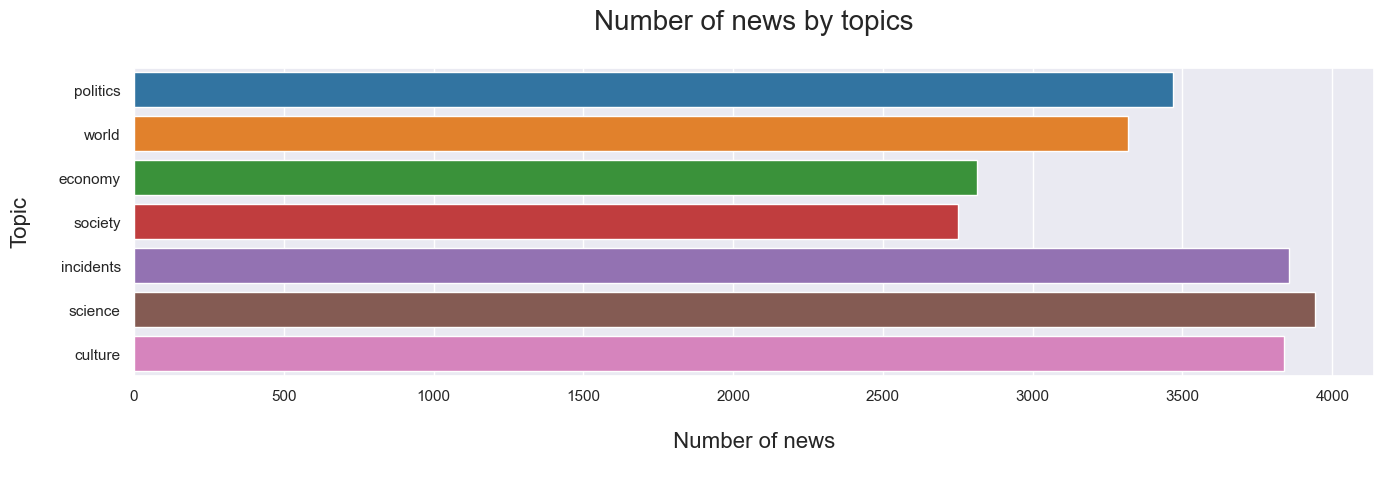

In [16]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16, 4))
sns.countplot(y=df["topic"], palette="tab10", ax=ax)
plt.xlabel("\n Number of news \n", fontsize=16)
plt.ylabel("Topic\n", fontsize=16)
plt.title("Number of news by topics\n", fontsize=20)
plt.show();

#### Вывод 

* Больше всего новостей в данном датасете на тему "наука". 

* Далее по количеству новостей идут категории "происшествия" и "культура". 

* Меньше всего новостей - на тему "общества". 

* Возможно, следует добавить статей по категории economy и society для сбалансированности данных.

### Распределения количества новостей по времени выпуска

In [17]:
df.datetime

0        19:51 01.11.2023
1        18:12 01.11.2023
2        17:37 01.11.2023
3        16:03 01.11.2023
4        15:56 01.11.2023
               ...       
25551    12:34 03.10.2023
25552    12:34 03.10.2023
25553    12:32 03.10.2023
25557    08:15 03.10.2023
25560    07:17 03.10.2023
Name: datetime, Length: 23985, dtype: object

Дата имеет строковый тип данных, преобразуем значения столбца в тип данных datetime и извлечем новые признаки: год выпуска статьи, месяц, день недели.  

In [18]:
df["datetime"] = pd.to_datetime(df["datetime"], format="%H:%M %d.%m.%Y")
df["year"] = df["datetime"].dt.year
df["month"] = df["datetime"].dt.month
df["weekday"] = df["datetime"].dt.day_name()

In [19]:
df.weekday.value_counts()

weekday
Tuesday      4136
Wednesday    4102
Thursday     4030
Monday       4024
Friday       3683
Saturday     2121
Sunday       1889
Name: count, dtype: int64

In [20]:
df.datetime.describe()

count                            23985
mean     2023-05-27 13:06:15.379612160
min                2021-04-13 09:00:00
25%                2023-04-06 10:49:00
50%                2023-09-12 08:35:00
75%                2023-10-19 14:41:00
max                2023-11-05 11:12:00
Name: datetime, dtype: object

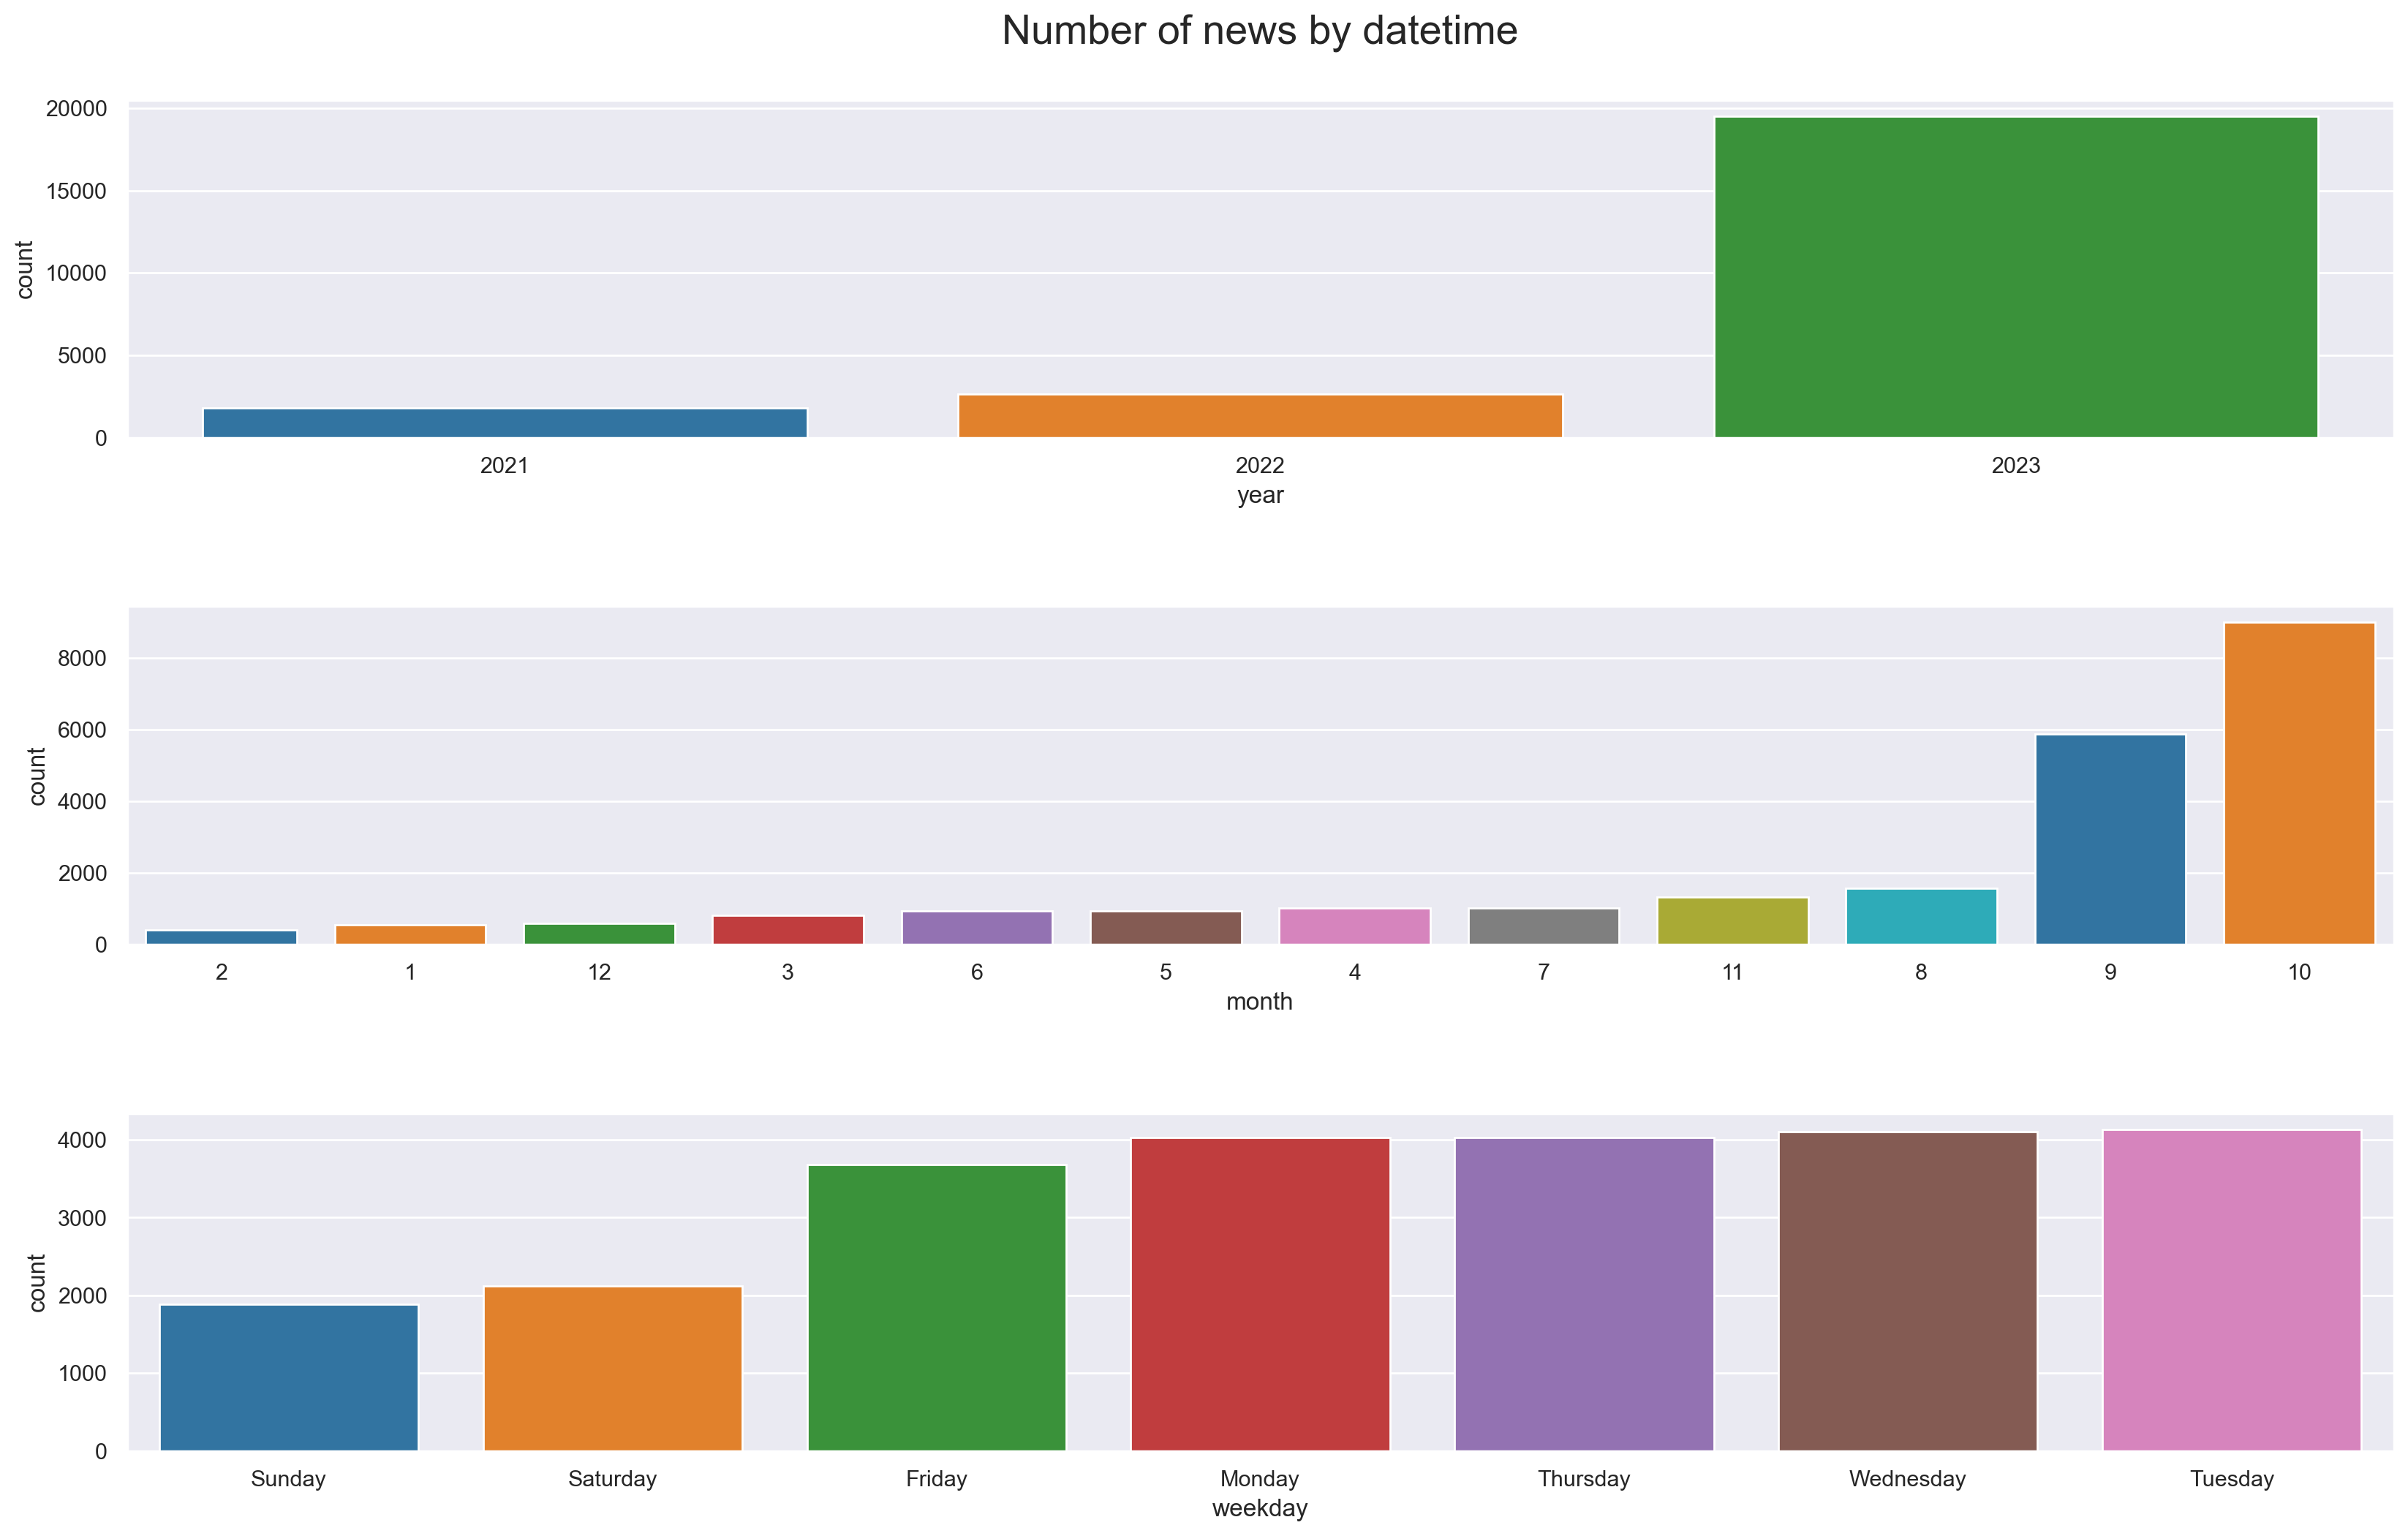

In [21]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(["year", "month", "weekday"]):
    sns.countplot(
        x=df[col],
        palette="tab10",
        ax=axs[ind],
        order=df[col].value_counts(ascending=True).index,
    )
axs[0].set_title("Number of news by datetime\n", fontsize=20)
plt.subplots_adjust(hspace=0.5);

#### Вывод:

* Датасет включает в себя новости, выпущенные в период с 4 апреля 2021 года по 1 ноября 2023 года.

* Больше всего новостей относятся к 2023 году.

* На сентябрь и ноябрь приходится большая часть новостей. 

* Меньше всего новостей в выходные и больше всего в начале недели.

### Текстовые статистики

Парсинг был сделан грубовато в основном тексте статьи, поэтому уберем лишние сниппеты заголовков других статей с помощью регулярного выражения, а также избавимся от указания локации, источника и автора статьи в самом начале и от подписей фото по возможности.

In [22]:
# Порядок применения обработок внутри функции важен(!)


def clean_text(text):

    # убираем вставки с заголовками других статей, узко, чтобы не тронуть лишнего
    text = re.sub(r"\.(?!\.)[^.]{3,}\n\n\nПоделиться\n\n", ". ", text)
    text = re.sub(r"\n+", " ", text)  # убираем перенос строки = заменяем на пробел
    # МОСКВА, 1 ноя — РИА Новости, Михаил Катков.
    text = re.sub(r"^[А-ЯЁ].{2,}\W{2}РИА Новости, [\w\s,]+\.", "", text)  # —-–
    # КАЛИНИНГРАД, 22 авг — РИА Новости. Картины...
    text = re.sub(r"^[А-ЯЁ].{2,}\W{2}РИА Новости\.", "", text)
    # подписи к фото
    text = re.sub(r"©.+медиабанк", " ", text)
    text = re.sub(r"©.+Photo.+[a-z]", " ", text)  # 122
    # Когда склеен пунктуатор и последующее слово: "говорится в статье.По мнению", чтобы потом правильно токенизировать
    text = re.sub(r"([.,:!?\)])(?=[а-яёa-z№А-ЯЁA-Z])", r"\1 ", text)
    # Когда склеен подзаголовок\подпись к фото и последующий текст: в городе Эр-Растан, СирияСреди представленных сцен
    text = re.sub(r"([а-я])([A-Я][а-я])", r"\1 \2", text)
    return text.lower().strip()

In [23]:
df.loc[23108]["content"][:100]

'КАЛИНИНГРАД, 22 авг — РИА Новости. Картины про непредсказуемые выходные, полет в космос и рыбалку ст'

In [24]:
df.loc[12].content[:100]

'МОСКВА, 1 ноя — РИА Новости, Михаил Катков. Попытки Киева присоединить к антироссийской коалиции стр'

In [25]:
df.loc[17283].content[3000:]

'е экспортировать весь архив, письма без вложений весят совсем немного. Наконец, в мессенджере WhatsApp (детище все той же Meta, то есть бывшего Facebook) есть возможность сохранить всю историю и переписку аккаунта.   в виде не только бэкапа, но и готового чата для Telegram — достаточно в настройках выбрать опцию "Экспорт чата" и во вкладке "Поделиться" отметить Telegram.Эксперт посоветовал вывести данные из хранилища Google и iCloud10 марта 2022, 14:17\n\n\nПоделиться\n\nХорошо забытое староеДля полной уверенности, что документы, фото и видео точно останутся под рукой и безо всяких ограничений, стоит задуматься о локальном оффлайн-хранилище. "Облака" — это, конечно, хорошо, но не так надежно, как хотелось бы.\n\n\n\n\n\n\n \n\n\nОпределитесь с объемом и бюджетом. Внешний жесткий диск формата 3,5 дюйма объемом четыре терабайта подорожал вдвое — до 15-18 тысячи рублей.Можно и вовсе замахнуться на сетевое хранилище NAS — мини-сервер, подключенный к сети из накопителей. Это обеспечит бесп

In [26]:
df.loc[22532].content

'МОСКВА, 14 окт — РИА Новости. В сирийском городе Эр-Растан в провинции Хомс нашли большую неповрежденную древнеримскую мозаику, сообщает Associated Press. Ее  назвали самым важным археологическим открытием с начала военного конфликта в стране 11 лет назад.Площадь произведения — 120 квадратных метров. © AP Photo / Omar SanadikiМозаика времен римской эпохи в городе Эр-Растан, Сирия© AP Photo / Omar SanadikiМозаика времен римской эпохи в городе Эр-Растан, СирияСреди представленных сцен — редкое изображение амазонок из римской мифологии и Троянской войны. Еще на мозаике есть образ Нептуна, древнеримского бога моря, и его 40 любовниц. \n\n\n\n\n\n\n\n\n\n\n\nРисунок был обнаружен в одной из древних построек. Раскопки еще идут, и ученые пока не могут определить тип этого здания. Пока неясно, была ли там общественная баня или что-то еще. В Египте обнаружили саркофаг казначея фараона Рамзеса II6 октября 2022, 18:44\n\n\nПоделиться\n\n'

In [27]:
df.loc[6].content

'МОСКВА, 1 ноя — РИА Новости. Госдума проголосовала за проекты постановлений о досрочном прекращении полномочий депутатов Вадима Белоусова и Василия Власова, сообщила пресс-служба Думы.Обсуждение проводилось в закрытом режиме.Депутаты проголосовали за прекращение полномочий парламентариев.\n\n\n\n\n\nКомиссия Госдумы по этике во вторник рассмотрела материалы от комитета по защите конкуренции и комиссии по регламенту и обеспечению деятельности Государственной думы о систематическом отсутствии на своих заседаниях депутатов Вадима Белоусова и Василия Власова и сочла достаточными основания для досрочного прекращения их полномочий. Она также приняла решение о представлении материалов по ним в комиссию по мандатным вопросам, в палату внесли проекты постановлений о лишении их полномочий.© РИА Новости / Владимир Федоренко\xa0|\xa0Перейти в медиабанкЧлен комиссии Государственной Думы РФ по регламенту и обеспечению деятельности Государственной Думы Василий Власов перед пленарным заседанием Госуд

In [28]:
%%time
df["content"] = df["content"].apply(clean_text)

Wall time: 9.41 s


In [29]:
df.loc[23108]["content"][:100]

'картины про непредсказуемые выходные, полет в космос и рыбалку стали лауреатами x фестиваля коротком'

In [30]:
df.loc[12].content[:100]

'попытки киева присоединить к антироссийской коалиции страны глобального юга провалились. при этом, к'

In [31]:
df.loc[17283].content[3000:]

'ывшего facebook) есть возможность сохранить всю историю и переписку аккаунта.   в виде не только бэкапа, но и готового чата для telegram — достаточно в настройках выбрать опцию "экспорт чата" и во вкладке "поделиться" отметить telegram. хорошо забытое старое для полной уверенности, что документы, фото и видео точно останутся под рукой и безо всяких ограничений, стоит задуматься о локальном оффлайн-хранилище. "облака" — это, конечно, хорошо, но не так надежно, как хотелось бы.   определитесь с объемом и бюджетом. внешний жесткий диск формата 3,5 дюйма объемом четыре терабайта подорожал вдвое — до 15-18 тысячи рублей. можно и вовсе замахнуться на сетевое хранилище nas — мини-сервер, подключенный к сети из накопителей. это обеспечит бесперебойный доступ к большому массиву данных, например с камер наблюдений (некоторые облачные сервисы попросту отключили российских пользователей). проще и дешевле подключиться к wi-fi-роутеру через usb внешнего накопителя — практически все современные марш

In [32]:
df.loc[22532].content

'в сирийском городе эр-растан в провинции хомс нашли большую неповрежденную древнеримскую мозаику, сообщает associated press. ее  назвали самым важным археологическим открытием с начала военного конфликта в стране 11 лет назад. площадь произведения — 120 квадратных метров.  мозаика времен римской эпохи в городе эр-растан, сирия среди представленных сцен — редкое изображение амазонок из римской мифологии и троянской войны. еще на мозаике есть образ нептуна, древнеримского бога моря, и его 40 любовниц.  рисунок был обнаружен в одной из древних построек. раскопки еще идут, и ученые пока не могут определить тип этого здания. пока неясно, была ли там общественная баня или что-то еще.'

In [33]:
df.loc[6].content

'госдума проголосовала за проекты постановлений о досрочном прекращении полномочий депутатов вадима белоусова и василия власова, сообщила пресс-служба думы. обсуждение проводилось в закрытом режиме. депутаты проголосовали за прекращение полномочий парламентариев. комиссия госдумы по этике во вторник рассмотрела материалы от комитета по защите конкуренции и комиссии по регламенту и обеспечению деятельности государственной думы о систематическом отсутствии на своих заседаниях депутатов вадима белоусова и василия власова и сочла достаточными основания для досрочного прекращения их полномочий. она также приняла решение о представлении материалов по ним в комиссию по мандатным вопросам, в палату внесли проекты постановлений о лишении их полномочий. ранее конституционный суд не принял к рассмотрению жалобу, поданную адвокатами от имени депутата госдумы вадима белоусова, приговоренного к десяти годам колонии за получение взятки в три миллиарда рублей и усомнившегося в конституционности законо

#### Посимвольные длины заголовков и основного текста

Посчитаем посимвольную длину заголовков и основного текста. 

In [34]:
df["len_title"] = df["title"].str.len()
df["len_subtitle"] = df["subtitle"].str.len()
df["len_content"] = df["content"].str.len()

In [35]:
df.groupby("topic")["len_title"].describe()

count       mean        std   min   25%   50%   75%   max
topic                                                                
culture    3838.0  59.648515  11.808798  14.0  52.0  62.0  69.0  75.0
economy    2813.0  63.720583   9.744612  25.0  58.0  66.0  72.0  75.0
incidents  3854.0  61.033991  10.515058  28.0  54.0  63.0  70.0  75.0
politics   3467.0  62.462359  10.729586  16.0  56.0  65.0  71.0  75.0
science    3942.0  61.387874   9.854176  27.0  55.0  63.0  69.0  88.0
society    2752.0  63.073765  10.002508  19.0  57.0  66.0  71.0  75.0
world      3319.0  64.371497   9.368887  16.0  59.0  67.0  72.0  75.0

In [36]:
df.groupby("topic")["len_title"].mean()

topic
culture      59.648515
economy      63.720583
incidents    61.033991
politics     62.462359
science      61.387874
society      63.073765
world        64.371497
Name: len_title, dtype: float64

In [37]:
df.groupby("topic")["len_subtitle"].describe()

count       mean        std  min   25%   50%   75%    max
topic                                                                
culture    3838.0  70.576863  24.747433  0.0  69.0  79.0  85.0   90.0
economy    2813.0  64.945254  24.432067  0.0  67.0  75.0  78.0   80.0
incidents  3854.0  72.952517   7.793172  0.0  70.0  75.0  78.0   80.0
politics   3467.0  73.160946  20.094412  0.0  72.0  78.0  84.0   90.0
science    3942.0  31.806443  39.930310  0.0   0.0   0.0  79.0  101.0
society    2752.0  61.598474  27.572839  0.0  64.0  74.0  78.0   80.0
world      3319.0  73.058753  10.066170  0.0  71.0  76.0  78.0   80.0

In [38]:
df.groupby("topic")["len_content"].describe()

count         mean          std    min      25%     50%      75%  \
topic                                                                          
culture    3838.0  1539.781918  1622.578927   80.0   793.00  1104.5  1639.75   
economy    2813.0  1639.464629  1323.083560   60.0   968.00  1392.0  1939.00   
incidents  3854.0  1123.626622   686.191417   98.0   704.25   977.0  1354.75   
politics   3467.0  1249.988463  1053.200436   66.0   700.00  1037.0  1498.00   
science    3942.0  2806.110096  2312.920526   83.0  1095.00  2158.0  3406.50   
society    2752.0  1659.716933  1420.852651   98.0   888.75  1304.0  1893.25   
world      3319.0  1920.861404  1049.297963  151.0  1067.00  1789.0  2580.00   

               max  
topic               
culture    28467.0  
economy    21127.0  
incidents   9317.0  
politics   21231.0  
science    18092.0  
society    16558.0  
world      13616.0

Посмотрим, как они выглядят в разрезе каждой категории.

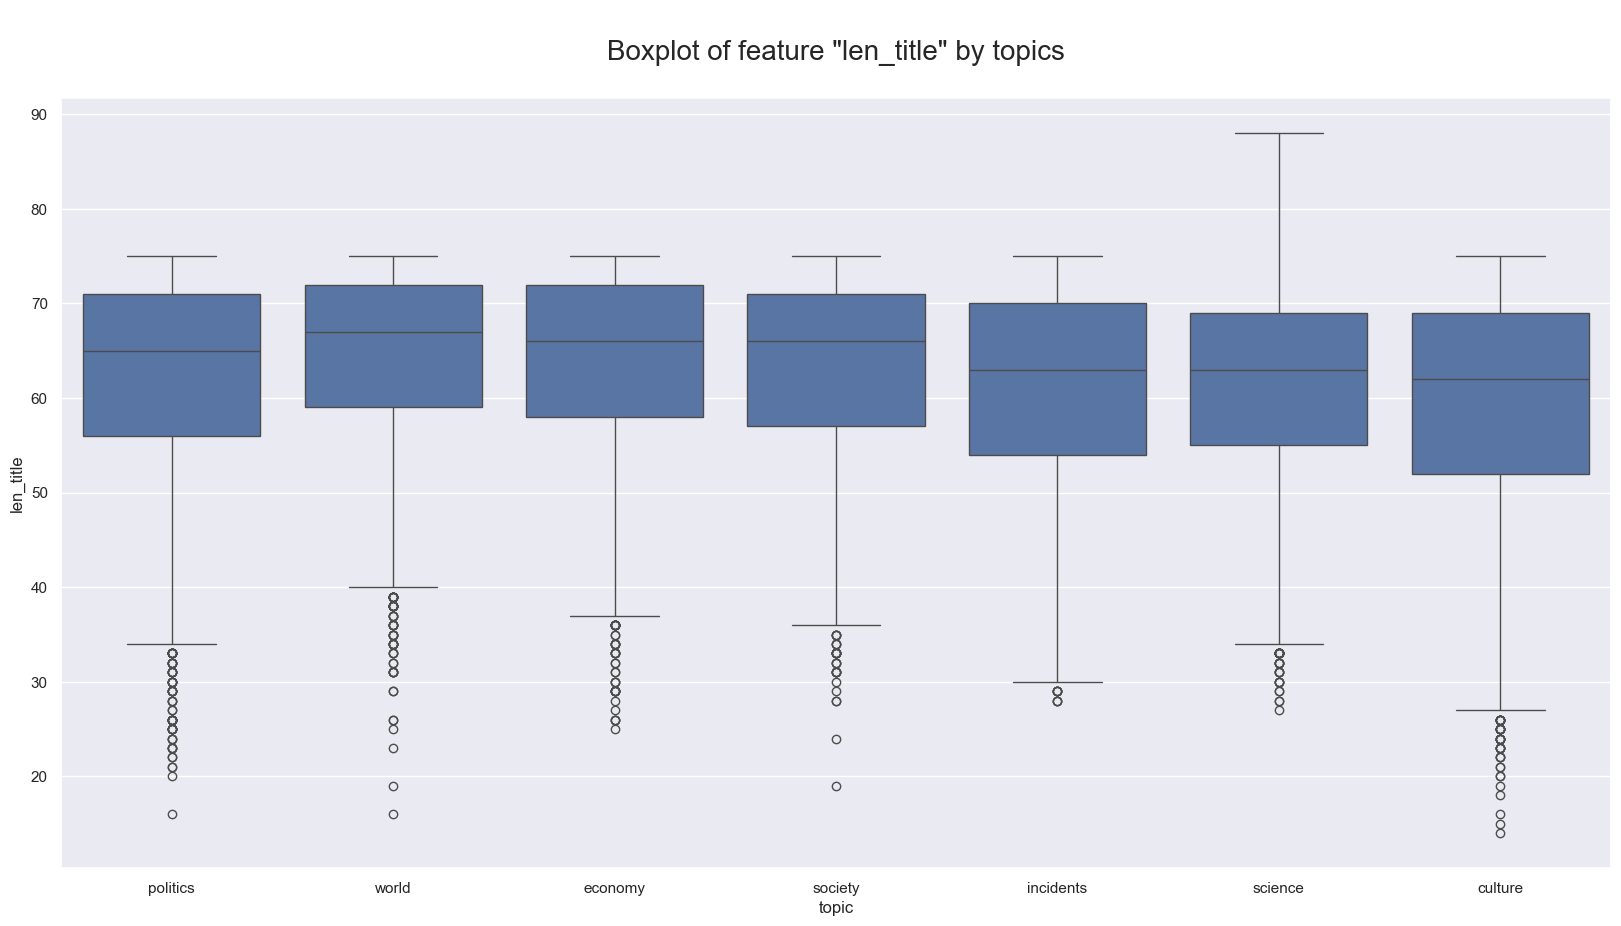

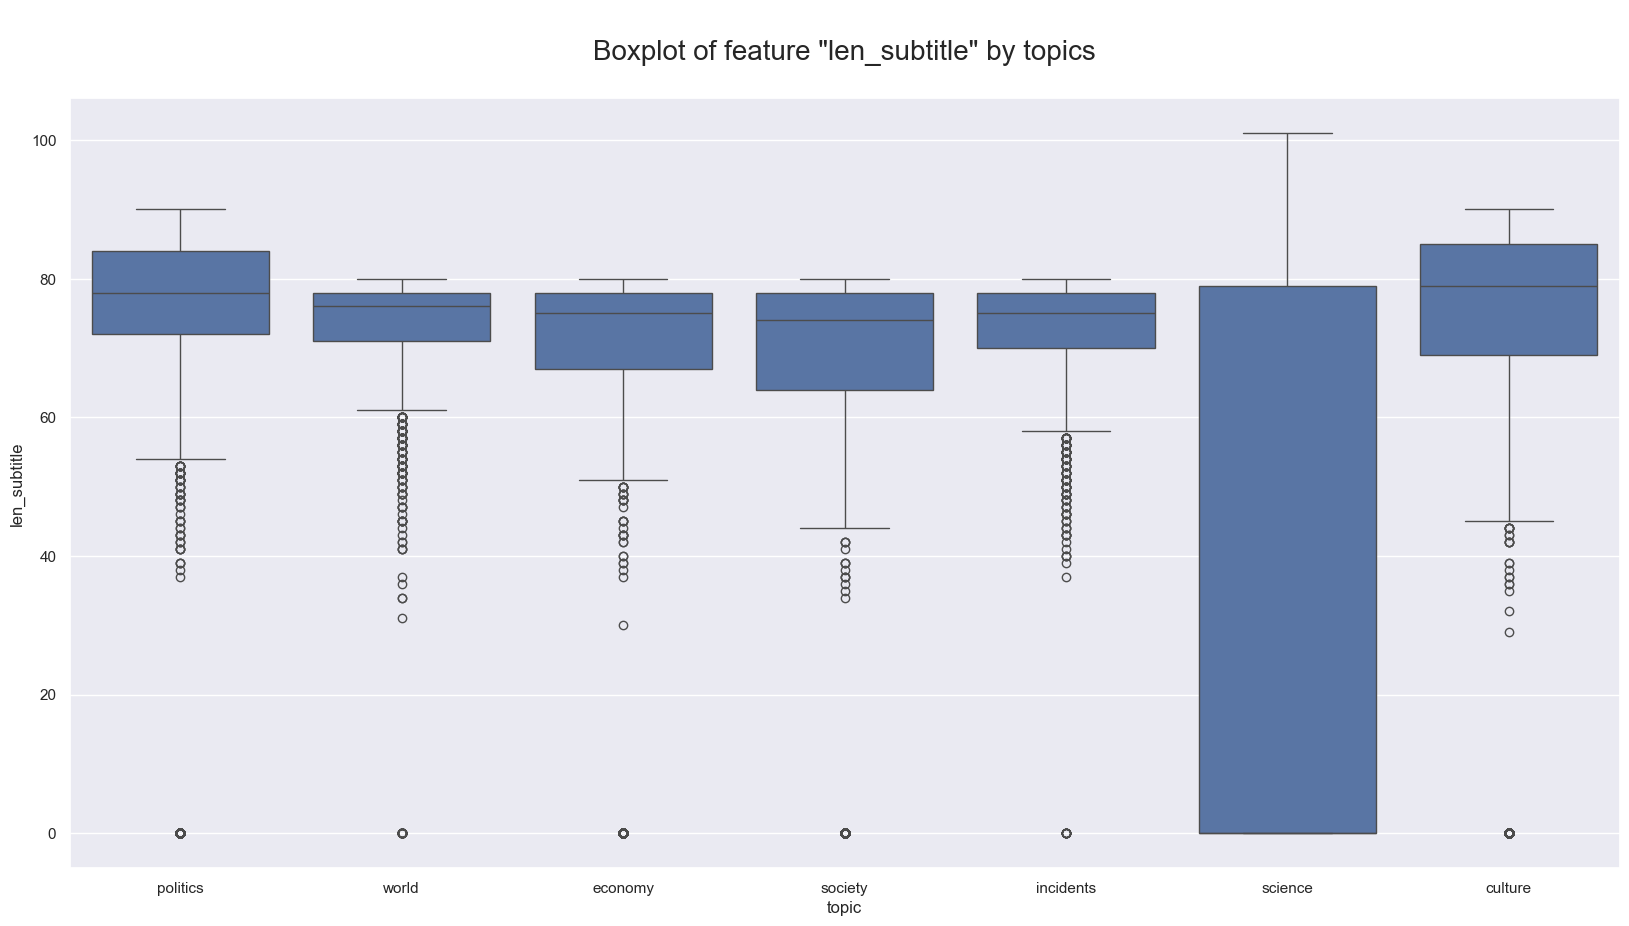

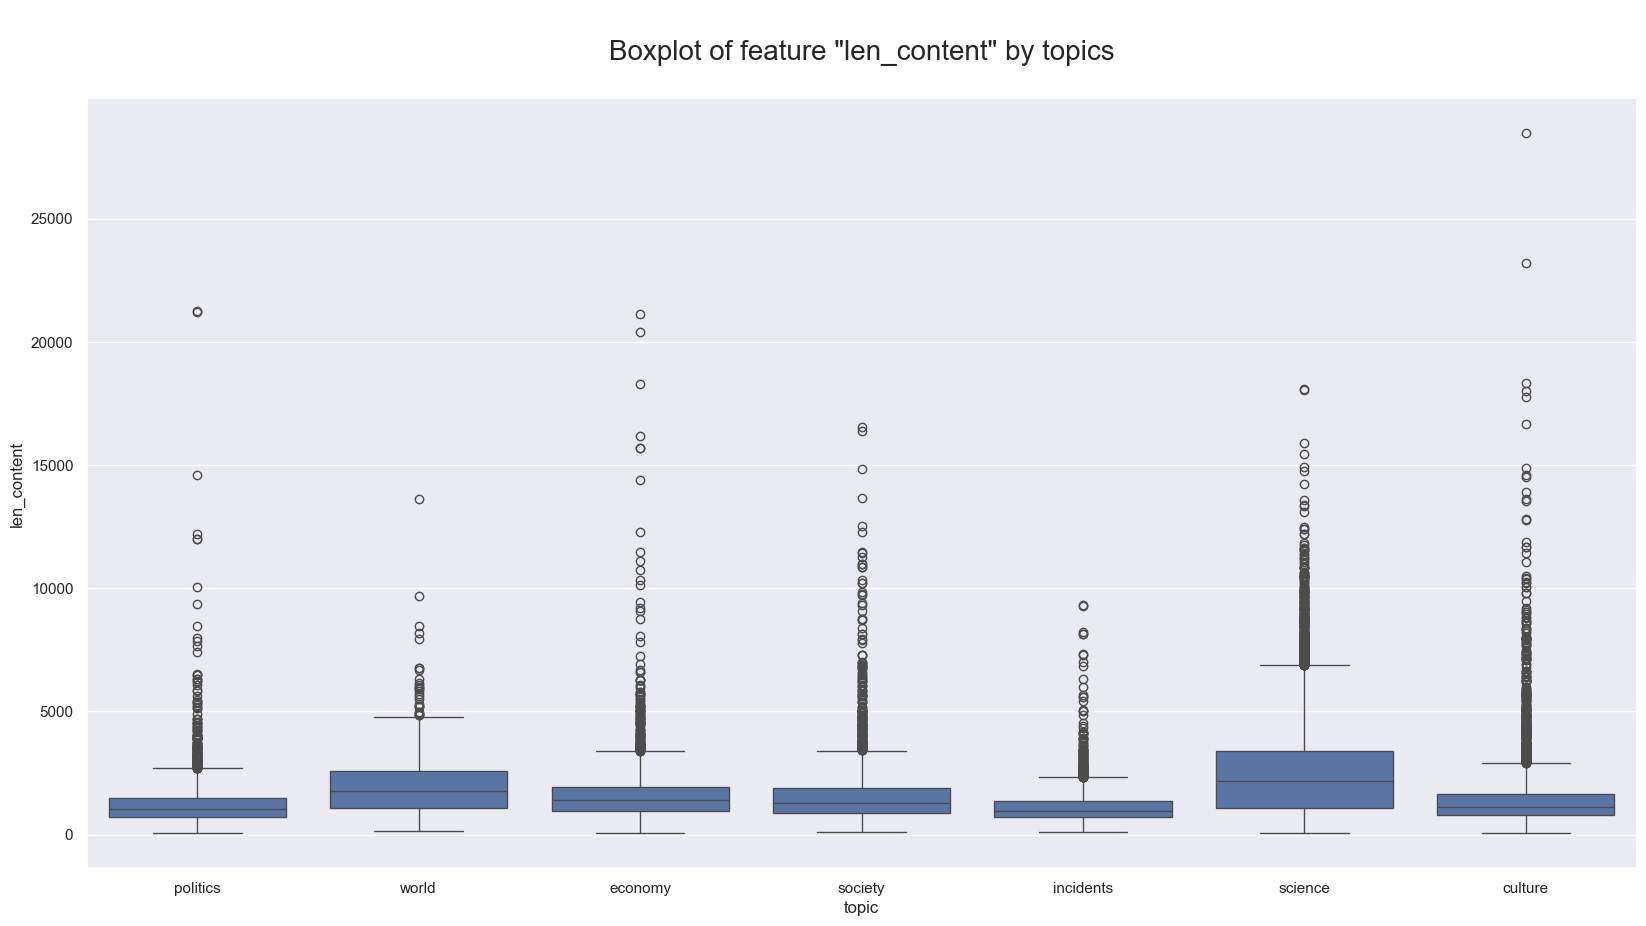

In [39]:
for col in ["len_title", "len_subtitle", "len_content"]:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'\nBoxplot of feature "{col}" by topics\n', fontsize=20)

Отдельно посмотрим на распределения характеристик длин заголовка и текста.

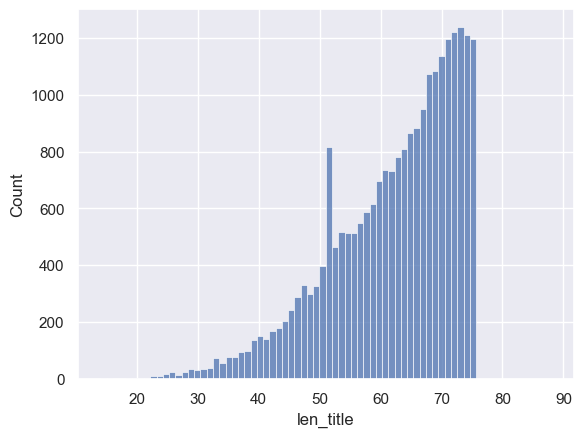

In [40]:
sns.histplot(df.len_title);

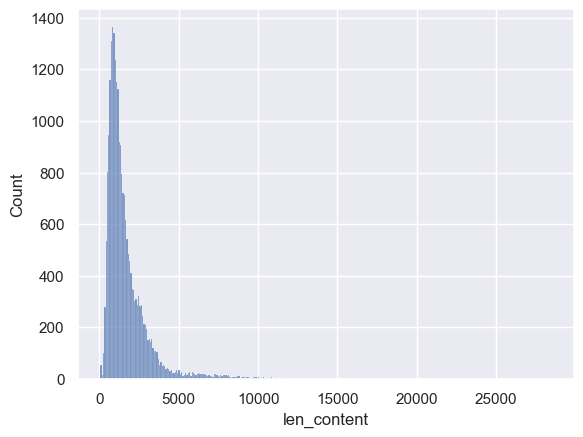

In [41]:
sns.histplot(df.len_content);

Распределения похожи на логнормальные.

Логарифмируем длину заголовка и текста и проверим распределение

In [42]:
df["log_len_title"] = np.log(df["len_title"])
df["log_len_content"] = np.log(df["len_content"])

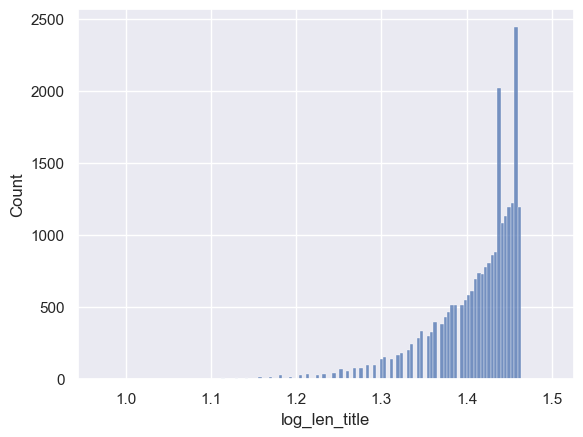

In [43]:
sns.histplot(np.log(df["log_len_title"]));

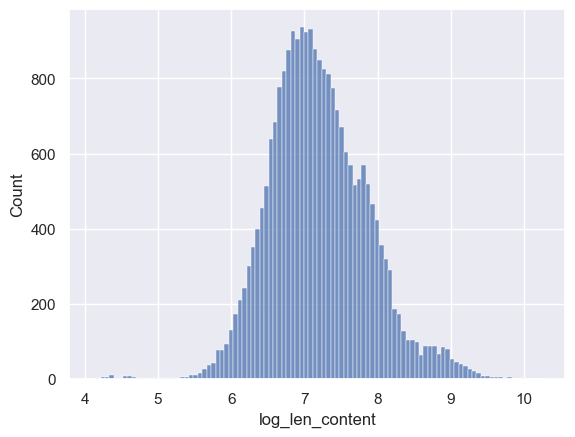

In [44]:
sns.histplot(df["log_len_content"]);

После логарифмирования признак длины текста стал похож на нормальное распределение.

Воспользуемся критерием Шапиро-Уилка, чтобы проверить, насколько распределение длин заголовков близко к логнормальному.

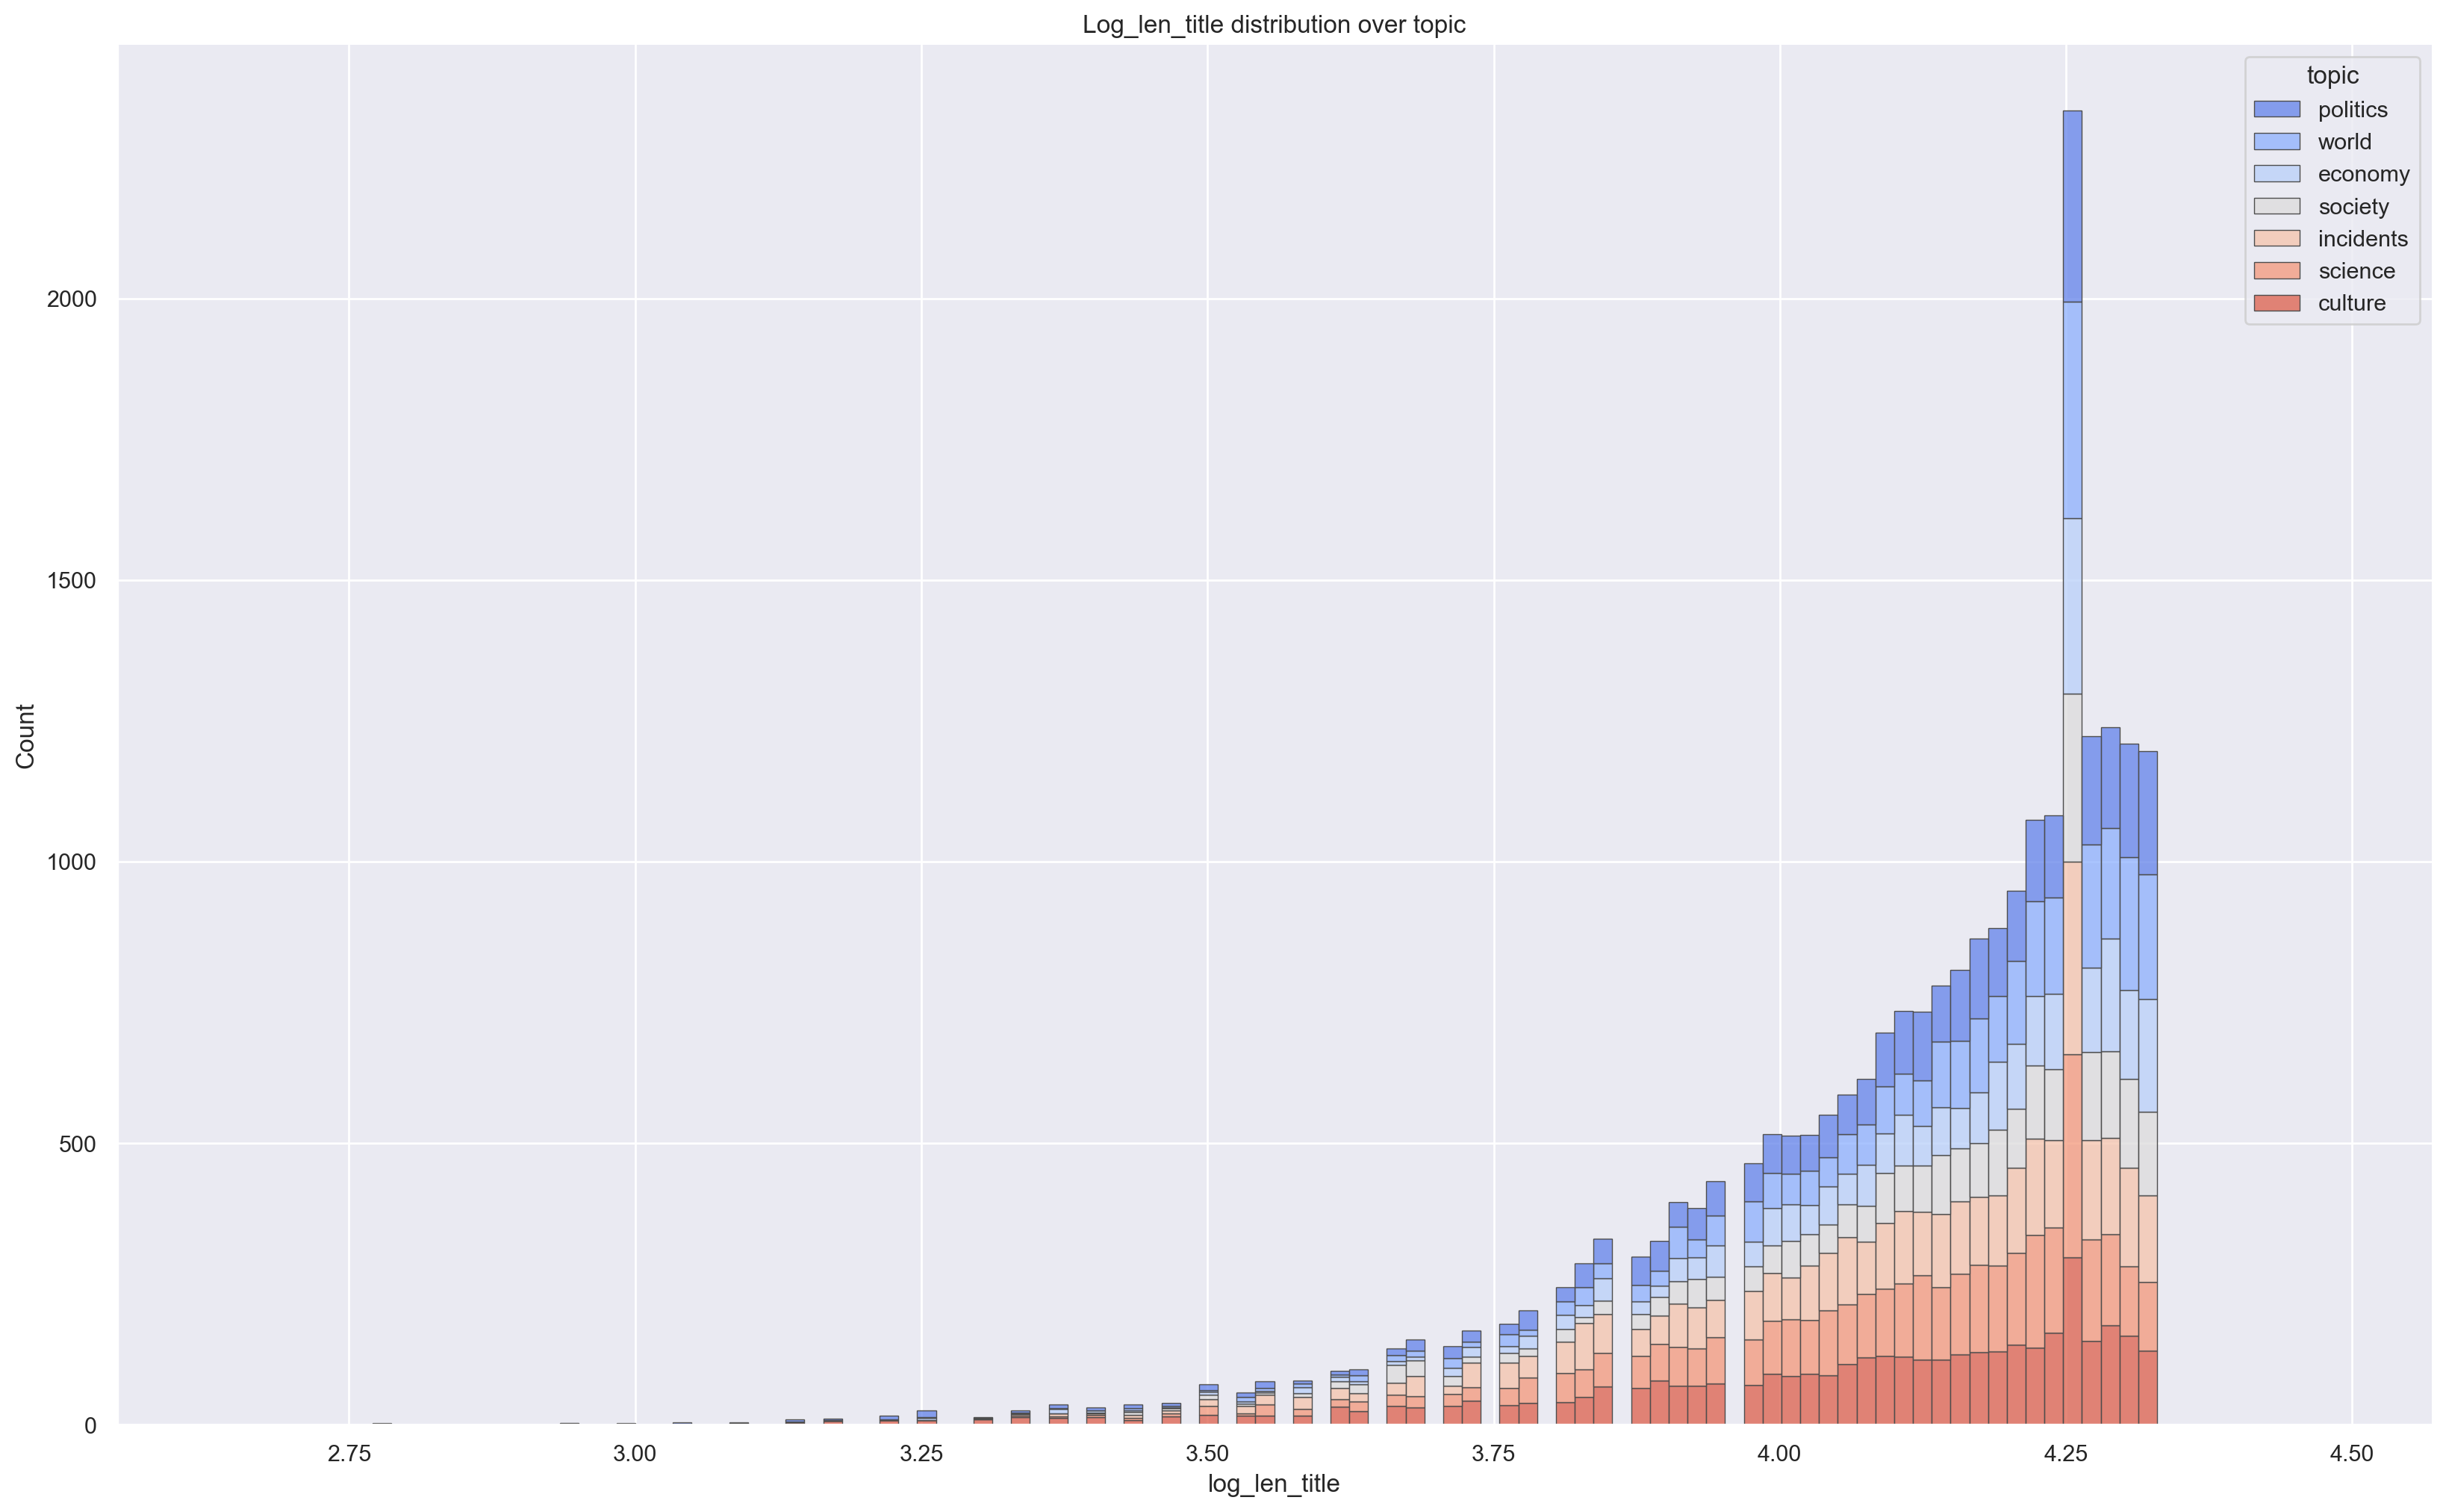

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="log_len_title",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=0.5,
)
axs.set_title("Log_len_title distribution over topic");

In [46]:
statistic, p = shapiro(df["log_len_title"])

print("P-significance:", p)

# Decision limit is 1%
if p < 0.01:
    print("The distribution of the length of title can be considered normal")
else:
    print("The distribution of the length of title cannot be considered normal")

P-significance: 0.0
The distribution of the length of title can be considered normal


##### Вывод:

* В среднем длина заголовка по всем категориям около 65 символов.

* Второй загловок по некоторым статьям недоступен, поэтому в будущем этот признак следует отбросить. 

- Длина текста имеет тяжелые хвосты, особенно по категориям: 'culture', 'society', 'economy'. Наиболее короткие новости относятся к теме incidents. 

* Признак длины текста имеет логнормальное распределение, признак длины заголовка близко к логнормальному распределению (это мы подтвердили критерием Шапиро-Уилка). Мы будем использовать эти признаки в логарифмированном виде при обучении нашей модели.

#### Вычисление словаря корпуса

С помощью токенизатора NLTK разобьем текст на токены.

In [47]:
%%time
df["tokens"] = df.content.apply(word_tokenize)

Wall time: 1min 7s


In [48]:
df[["content", "tokens"]]

content  \
0      президент украины владимир зеленский раскритик...   
1      в команде владимира зеленского начали критиков...   
2      минцифры технически готово к применению технол...   
3      на украине начнется гражданская война из-за ре...   
4      российские вертолеты показали уязвимость запад...   
...                                                  ...   
25551  причины, по которым национальное агентство по ...   
25552  поддержка участников специальной военной опера...   
25553  украина получила 65 миллиардов долларов помощи...   
25557  "индекс кофе с бутербродом" ("бутербродекс"), ...   
25560  курс рубля в начале торгов снижается против до...   

                                                  tokens  
0      [президент, украины, владимир, зеленский, раск...  
1      [в, команде, владимира, зеленского, начали, кр...  
2      [минцифры, технически, готово, к, применению, ...  
3      [на, украине, начнется, гражданская, война, из...  
4      [российские, вертолеты, показали, уязвимость, ...  
...                                                  ...  
25551  [причины, ,, по, которым, национальное, агентс...  
25552  [поддержка, участников, специальной, военной, ...  
25553  [украина, получила, 65, миллиардов, долларов, ...  
25557  [``, индекс, кофе, с, бутербродом, '', (, ``, ...  
25560  [курс, рубля, в, начале, торгов, снижается, пр...  

[23985 rows x 2 columns]

In [49]:
def flatten(tokenized_texts):
    return [word for text in tokenized_texts for word in text]

In [50]:
all_tokens = flatten(df["tokens"])

In [51]:
len(all_tokens)

6596817

In [52]:
all_tokens[:5]

['президент', 'украины', 'владимир', 'зеленский', 'раскритиковал']

Отфильтруем токены - оставим только буквенные и цифры и уберем стоп-слова, но предварительно сохраним токены с дефисом, чтобы их не потерять при обработке

In [53]:
tokens_with_hyphen = []
for token in all_tokens:
    if re.findall(r"[а-яA-Z]-[а-яA-Z]", token):
        tokens_with_hyphen.append(token)

In [54]:
tokens_with_hyphen = set(tokens_with_hyphen)
len(tokens_with_hyphen)

10162

In [55]:
stop_words = stopwords.words("russian")
stop_words.extend(
    [
        "что",
        "это",
        "так",
        "вот",
        "быть",
        "как",
        "в",
        "—",
        "к",
        "за",
        "из",
        "из-за",
        "на",
        "ок",
        "кстати",
        "который",
        "мочь",
        "весь",
        "еще",
        "также",
        "свой",
        "ещё",
        "самый",
        "ул",
        "риа",
        "новости",
        "фото",
        "предоставлено",
    ]
)

In [56]:
def filter_tokens(tokens):
    return [
        token
        for token in tokens
        if (token not in stop_words and token.isalnum())
        or (token in tokens_with_hyphen and token not in stop_words)
    ]

In [57]:
%%time
df["tokens"] = df["tokens"].apply(filter_tokens)

Wall time: 17.9 s


In [58]:
df[["content", "tokens"]]

content  \
0      президент украины владимир зеленский раскритик...   
1      в команде владимира зеленского начали критиков...   
2      минцифры технически готово к применению технол...   
3      на украине начнется гражданская война из-за ре...   
4      российские вертолеты показали уязвимость запад...   
...                                                  ...   
25551  причины, по которым национальное агентство по ...   
25552  поддержка участников специальной военной опера...   
25553  украина получила 65 миллиардов долларов помощи...   
25557  "индекс кофе с бутербродом" ("бутербродекс"), ...   
25560  курс рубля в начале торгов снижается против до...   

                                                  tokens  
0      [президент, украины, владимир, зеленский, раск...  
1      [команде, владимира, зеленского, начали, крити...  
2      [минцифры, технически, готово, применению, тех...  
3      [украине, начнется, гражданская, война, репрес...  
4      [российские, вертолеты, показали, уязвимость, ...  
...                                                  ...  
25551  [причины, которым, национальное, агентство, пр...  
25552  [поддержка, участников, специальной, военной, ...  
25553  [украина, получила, 65, миллиардов, долларов, ...  
25557  [индекс, кофе, бутербродом, бутербродекс, отра...  
25560  [курс, рубля, начале, торгов, снижается, проти...  

[23985 rows x 2 columns]

In [59]:
tokens_filtered = flatten(df["tokens"])

In [60]:
f"Размер нелематизированного корпуса без стоп-слов {len(tokens_filtered)} токенов"

'Размер нелематизированного корпуса без стоп-слов 3971976 токенов'

In [61]:
f"Количество уникальных нелематизированных токенов: {len(set(tokens_filtered))}"

'Количество уникальных нелематизированных токенов: 222099'

#### Ключевые слова тематик

Посмотрим, какие ключевые слова чаще всего встречаются в заголовках статей каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

Wall time: 39.7 s


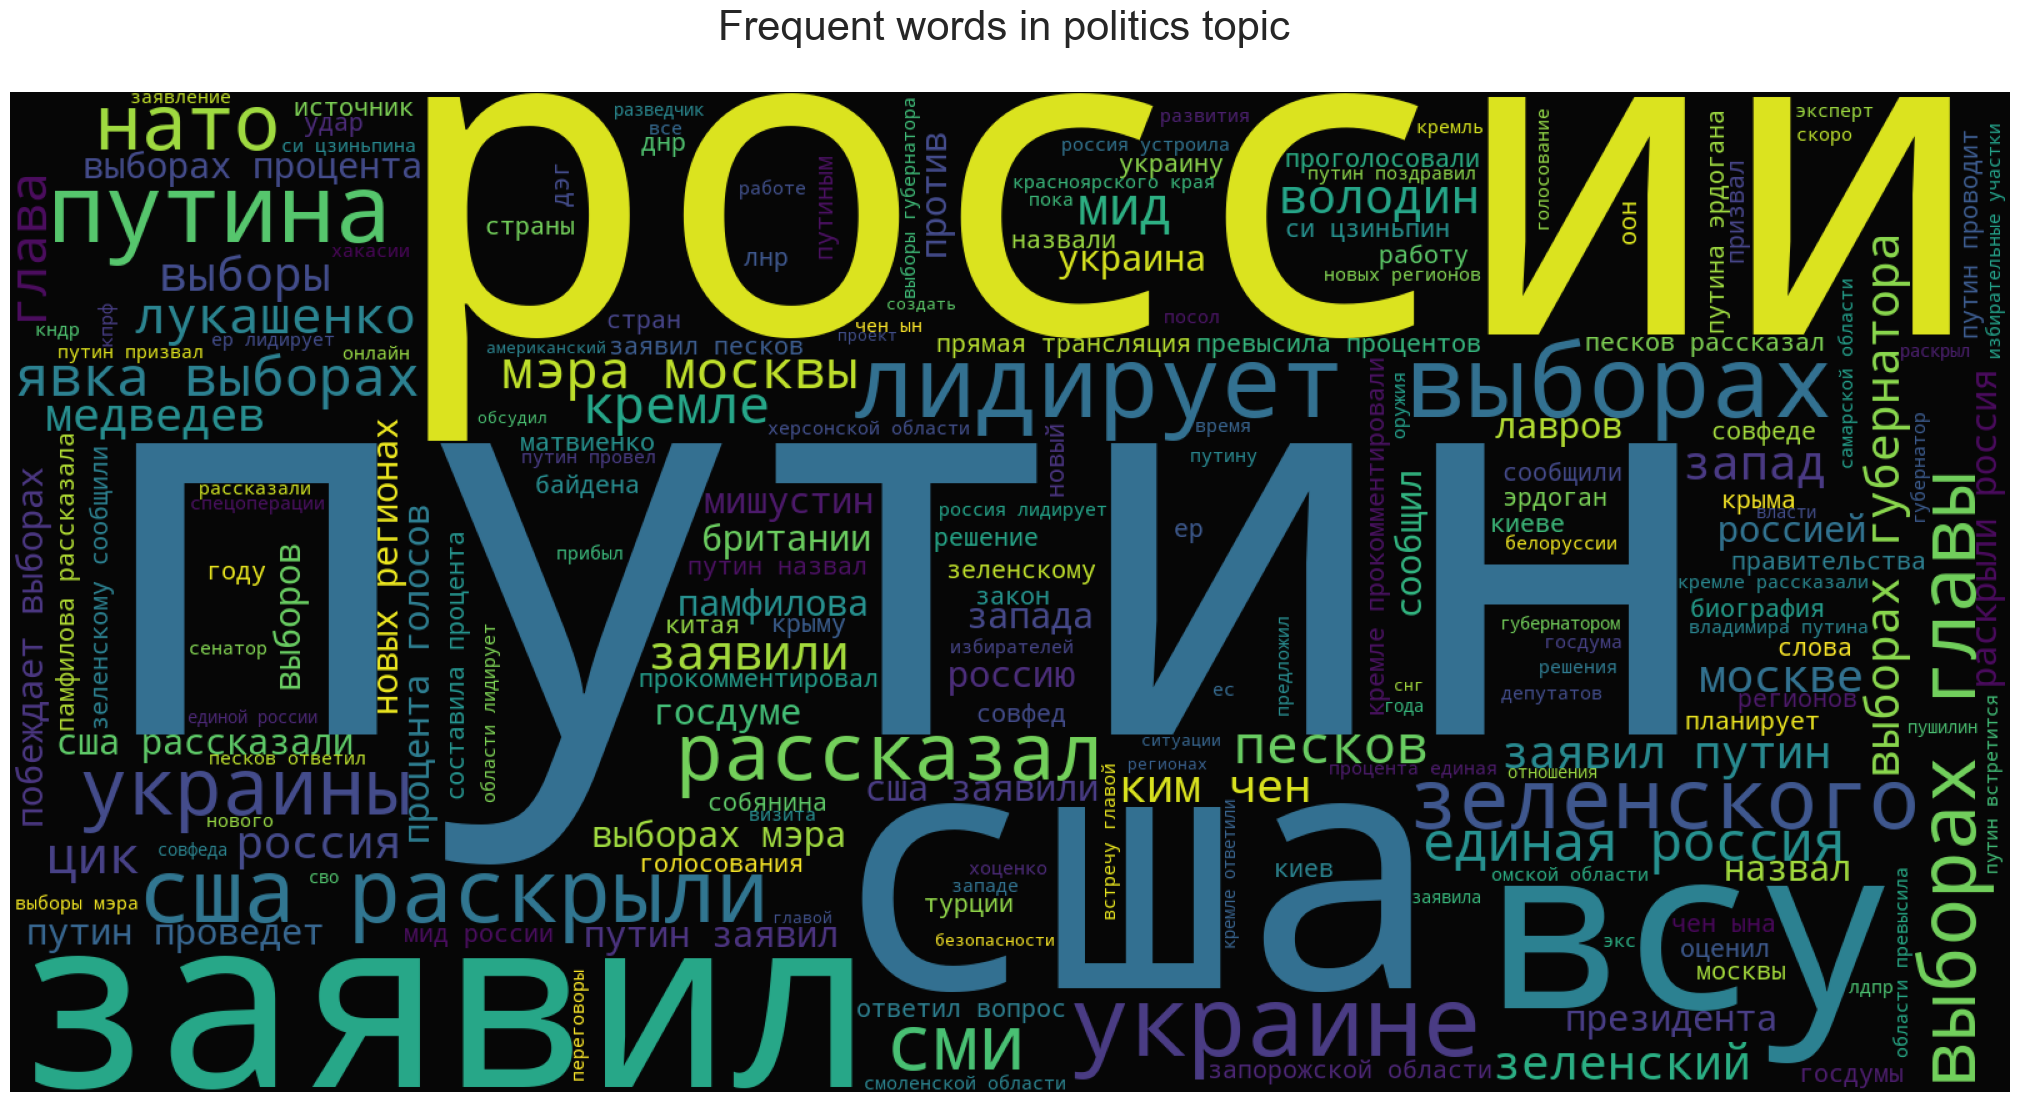

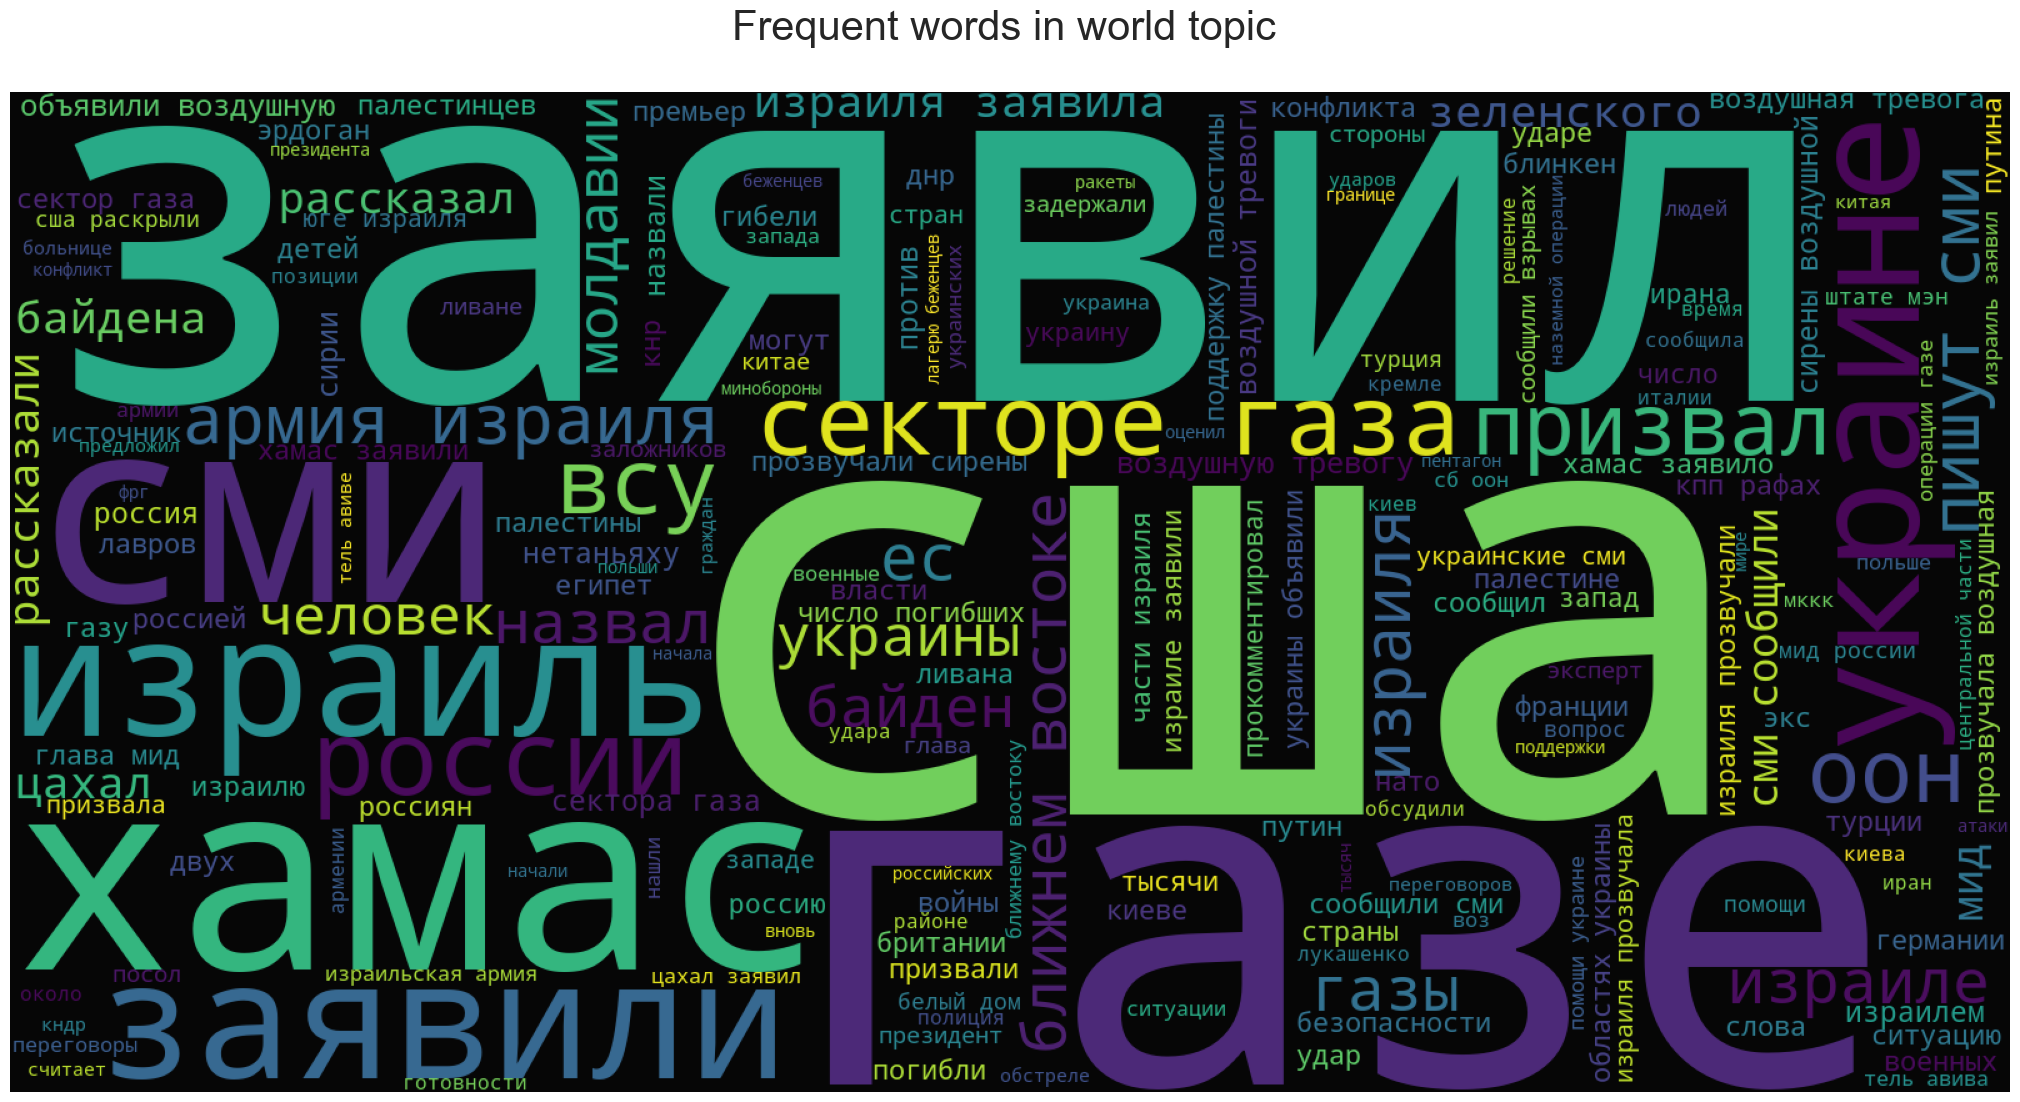

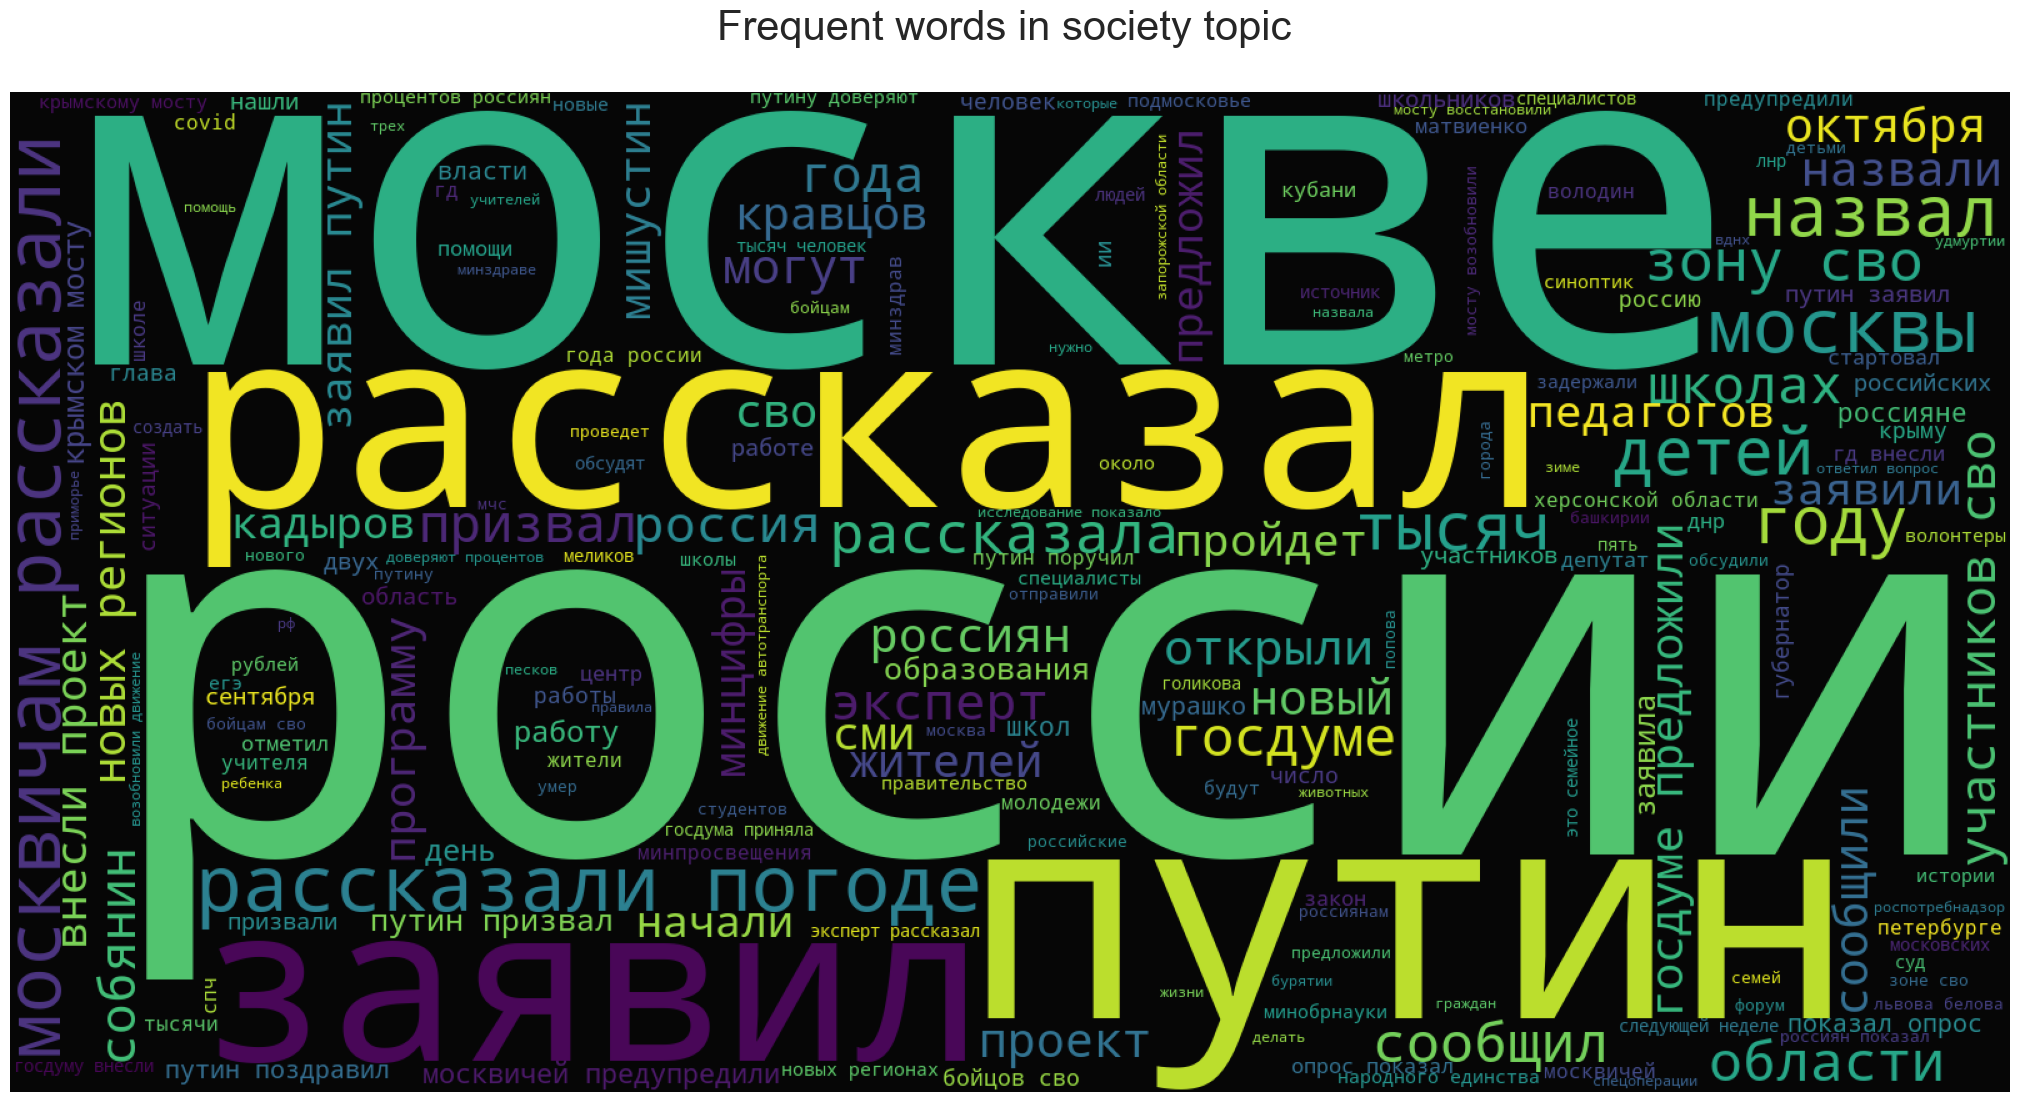

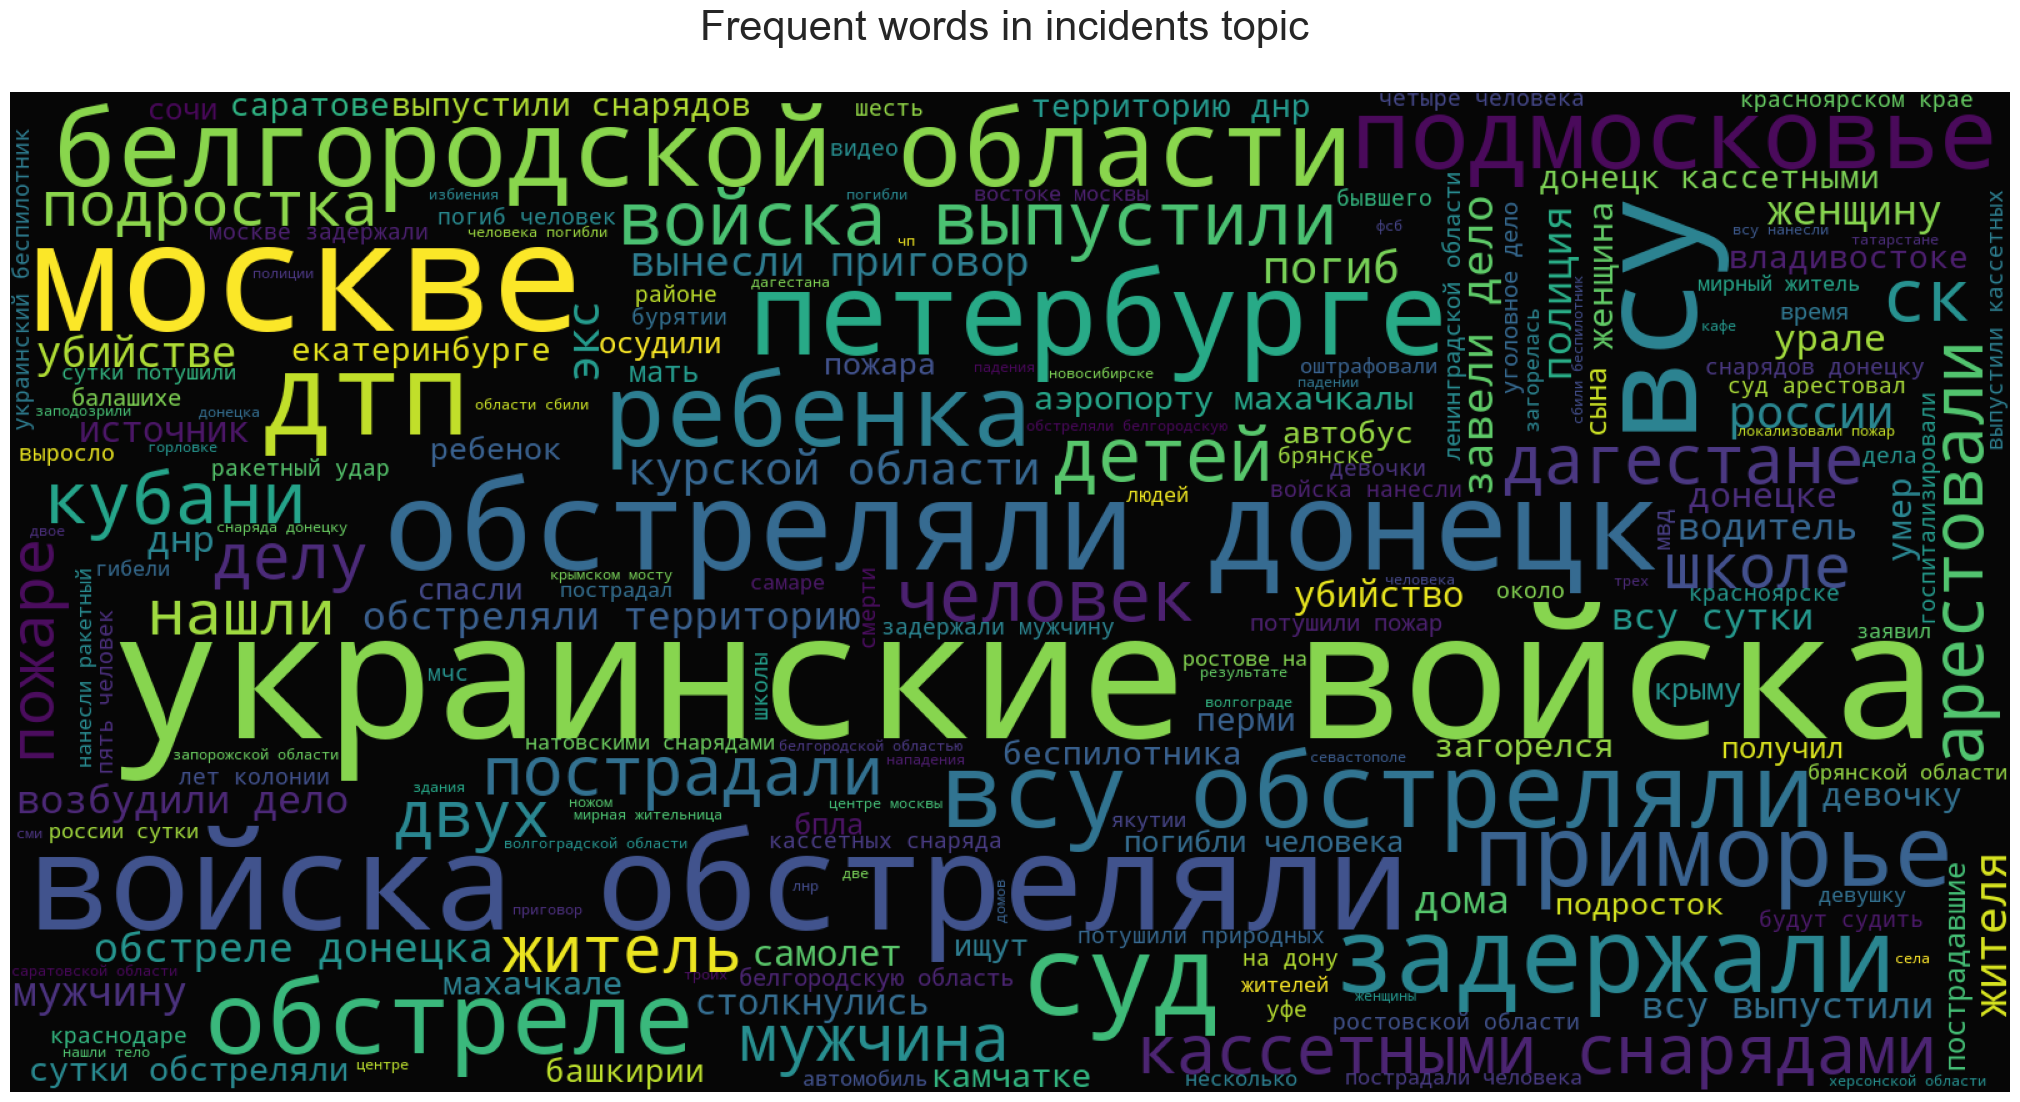

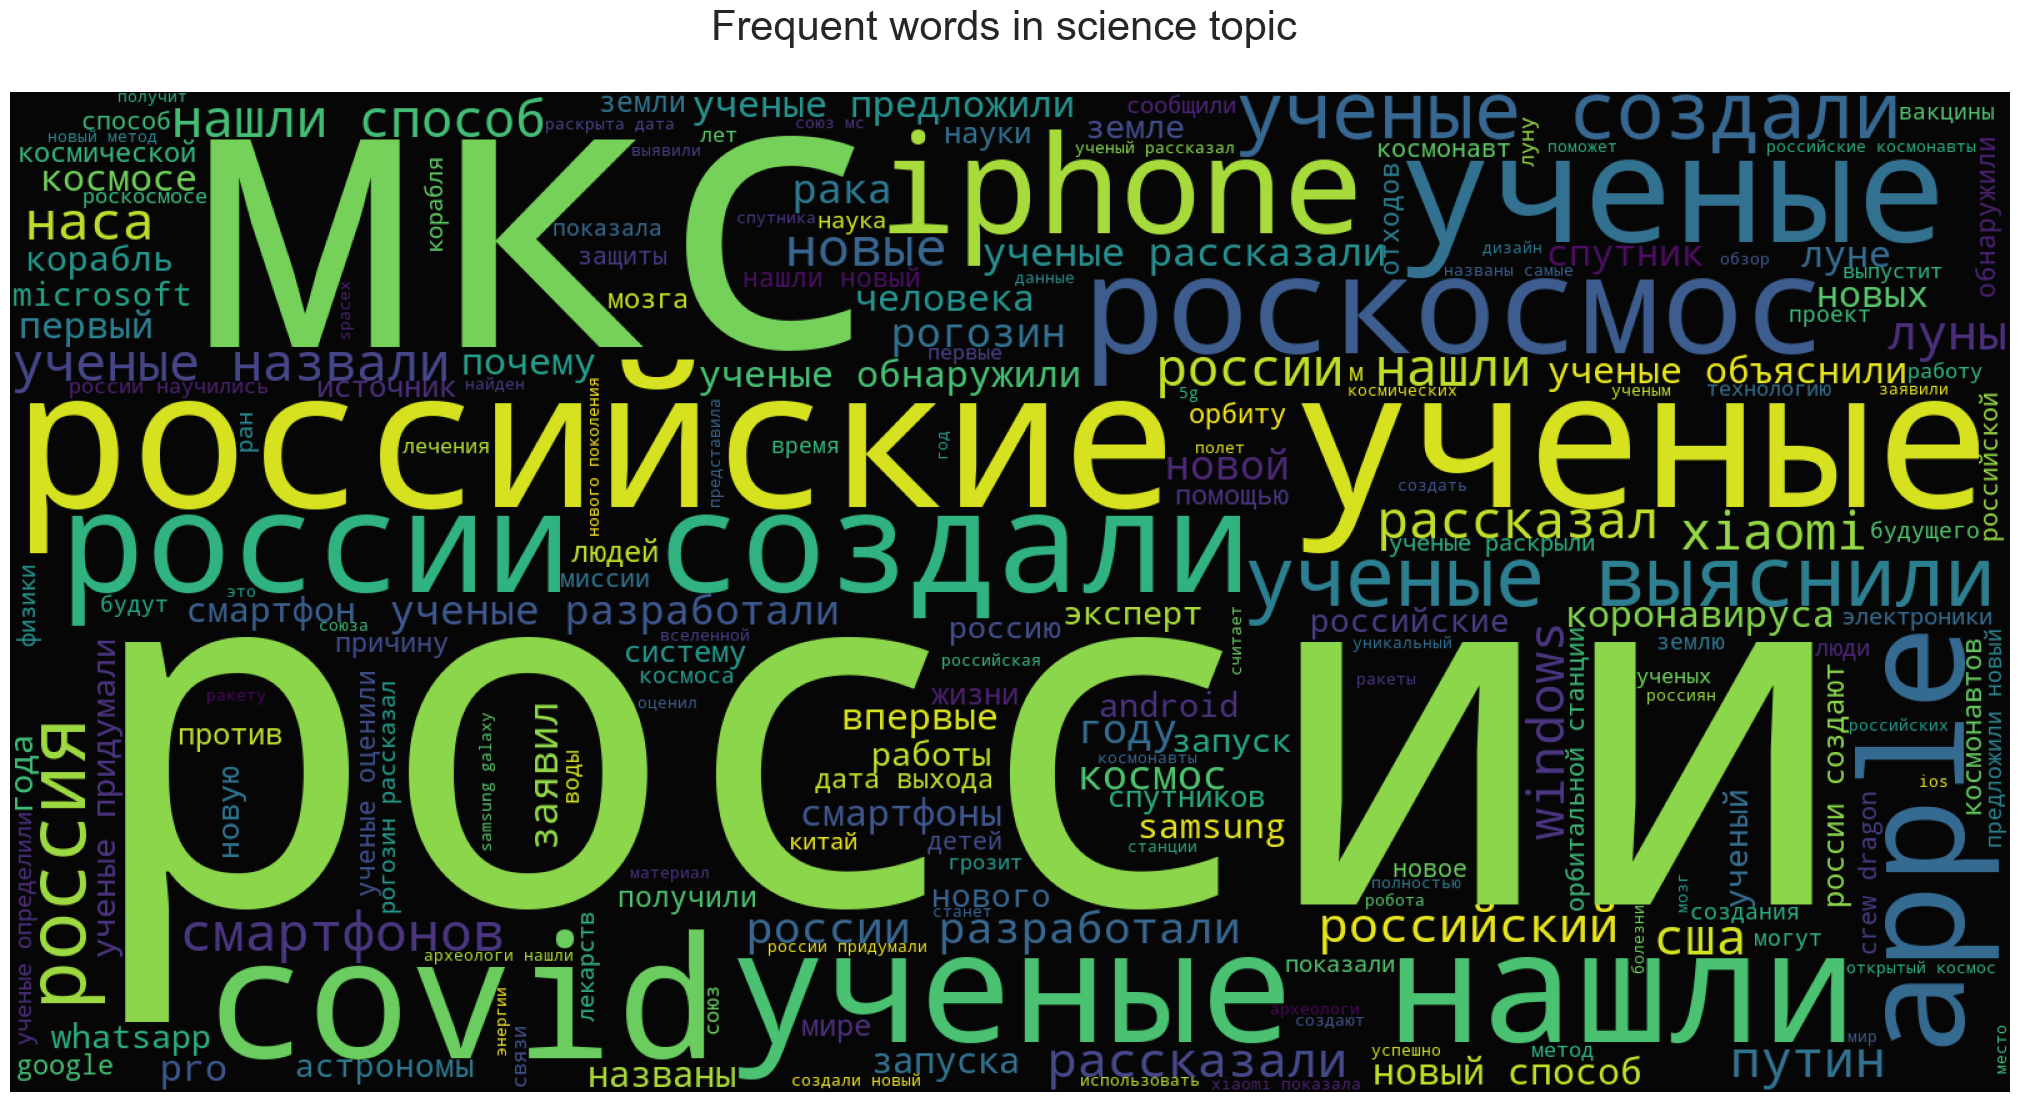

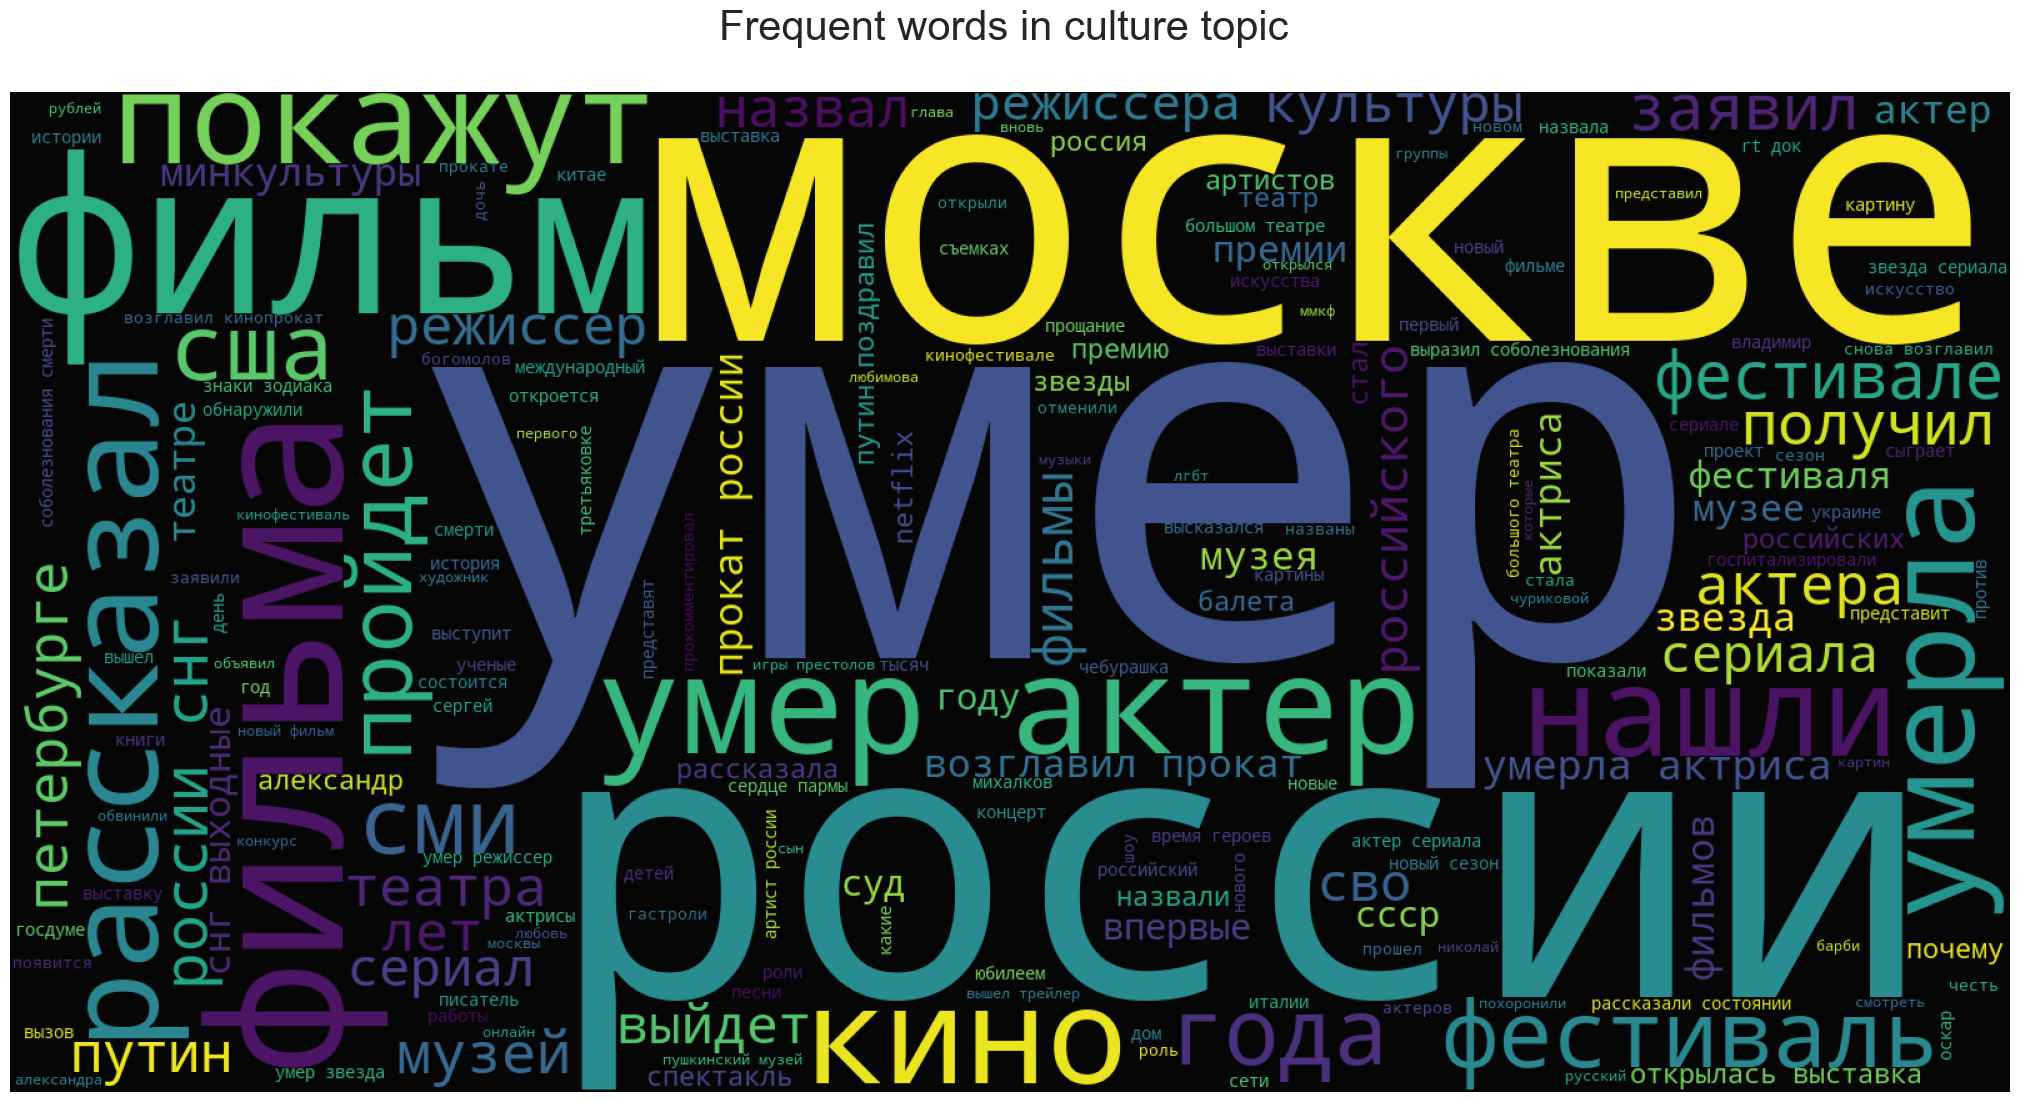

In [62]:
%%time
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(" ").explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic \n", fontsize=30)
    ax.imshow(wc, alpha=0.98)

### Общий вывод

На данном этапе мы провели первичный анализ датасета. 

* В данном датасете представлены статьи по 7 тематикам: science (наука), incidents (происшествия), culture (культура), politics (политика), world (новости в мире), economy (экономика), society (общество). 
Статьи распределены по тематикам почти равномерно: немного проседает тема society and economy.  

* В датасете представлены новостные статьи с 2021 по 2023 год. Большая часть новостей относится к 2023 году. (Выгрузка осуществлялась в обратном хронологическом порядке.) 
По дням недели на текущих данных можно судить больше. Меньше всего новостей выходит в выходные и больше всего в первые три дня рабочей недели - понедельник, вторник, среда. 

* Не у всех статей есть подзаголовок, поэтому в дальнейшем мы его из признаков исключим. В среднем длина заголовка по всем категориям около 65 символов. Длина текста имеет тяжелые хвосты, особенно по категориям 'economy', 'science' и 'culture'. А также эти признаки распределены логнормально. Их следует логарифмировать перед обучением модели.  

* Мы также проанализировали основные ключевые слова, которые наводят на гипотезу о том, что статьи разных тематик могут быть сильно похожи по доминирующим ключевым словам и тем самым негативно влиять на модель. Это нужно будет иметь в виду при построоении модели.

* Размер нелематизированного корпуса без стоп-слов: 3 971 976. 

Финальный датафрейм

In [63]:
df = df.drop(["subtitle", "len_subtitle"], axis=1)
df.tail()

url  \
25551       https://ria.ru/20231003/bank-1900142093.html   
25552   https://ria.ru/20231003/byudzhet-1900141992.html   
25553    https://ria.ru/20231003/ukraina-1900141296.html   
25557  https://ria.ru/20231003/buterbrodeks-190009318...   
25560     https://ria.ru/20231003/dollar-1900090300.html   

                                                   title  \
25551  Венгерский ОТР добился исключения из украинско...   
25552  Силуанов назвал обороноспособность России прио...   
25553  Минфин Украины подсчитал объем западной помощи...   
25557  "Бутербродекс" в первой половине сентября выро...   
25560  Курс доллара впервые с 14 августа поднялся выш...   

                                                 content            datetime  \
25551  причины, по которым национальное агентство по ... 2023-10-03 12:34:00   
25552  поддержка участников специальной военной опера... 2023-10-03 12:34:00   
25553  украина получила 65 миллиардов долларов помощи... 2023-10-03 12:32:00   
25557  "индекс кофе с бутербродом" ("бутербродекс"), ... 2023-10-03 08:15:00   
25560  курс рубля в начале торгов снижается против до... 2023-10-03 07:17:00   

         topic  year  month  weekday  len_title  len_content  log_len_title  \
25551  economy  2023     10  Tuesday         73         1643       4.290459   
25552  economy  2023     10  Tuesday         61         1258       4.110874   
25553  economy  2023     10  Tuesday         66         1046       4.189655   
25557  economy  2023     10  Tuesday         61         1455       4.110874   
25560  economy  2023     10  Tuesday         58         1198       4.060443   

       log_len_content                                             tokens  
25551         7.404279  [причины, которым, национальное, агентство, пр...  
25552         7.137278  [поддержка, участников, специальной, военной, ...  
25553         6.952729  [украина, получила, 65, миллиардов, долларов, ...  
25557         7.282761  [индекс, кофе, бутербродом, бутербродекс, отра...  
25560         7.088409  [курс, рубля, начале, торгов, снижается, проти...

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23985 entries, 0 to 25560
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   url              23985 non-null  object        
 1   title            23985 non-null  object        
 2   content          23985 non-null  object        
 3   datetime         23985 non-null  datetime64[ns]
 4   topic            23985 non-null  object        
 5   year             23985 non-null  int32         
 6   month            23985 non-null  int32         
 7   weekday          23985 non-null  object        
 8   len_title        23985 non-null  int64         
 9   len_content      23985 non-null  int64         
 10  log_len_title    23985 non-null  float64       
 11  log_len_content  23985 non-null  float64       
 12  tokens           23985 non-null  object        
dtypes: datetime64[ns](1), float64(2), int32(2), int64(2), object(6)
memory usage: 2.9+ MB


In [65]:
df.to_pickle("ria_news_cleaned.p", compression="gzip")